# Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# pywsd: using lemmatize_sentence
# emot: working with emojis and emoticons
# lime: lime
# shap: shap
# !pip install -r requirements.txt
!pip install -q pywsd emot lime shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.6/31.6 MB 15.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.5/61.5 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 32.1 MB/s eta 0:00:00


In [3]:
# imports
import math
import pandas as pd
import numpy as np
import scipy as sp
import random
import os
import re
import json
from itertools import product
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 500)

# plots
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
plt.style.use('ggplot')

# text preprocessing
import re
import nltk
import emot
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from emot.emo_unicode import UNICODE_EMOJI, EMOTICONS_EMO
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')
from pywsd.utils import lemmatize_sentence

# feature extraction / vectorization
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler

# model building
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score

# evaluation & storing models
import pickle
import joblib
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import log_loss

from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer

from lime.lime_text import LimeTextExplainer
import shap

# word2vec + lstm pytorch
import gensim.downloader as api
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import lime
from lime import lime_text
from sklearn.pipeline import make_pipeline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
Warming up PyWSD (takes ~10 secs)... took 9.350993633270264 secs.


In [4]:
DATA_DIR = '/content/drive/MyDrive/sa-yen/data/'
MODEL_DIR = '/content/drive/MyDrive/sa-yen/models/'
IMAGE_DIR = '/content/drive/MyDrive/sa-yen/images/'

# DATA_DIR = 'data/'
# MODEL_DIR = 'models/'
# IMAGE_DIR = 'images/'

# Sampling & balancing the dataset

In [ ]:
def load_data_each_category(category):
    path = DATA_DIR + category + '/' + category + '/'
    files = os.listdir(path)
    dfs = []
    for file in files:
        df = pd.read_csv(path + file)
        dfs.append(df)

    final_df = dfs[0]
    for df in dfs[1:]:
        final_df = pd.concat([final_df, df])

    return final_df

def sample_each_class(df, num_each_class):
    df_pos = df[df.overall == 1].sample(num_each_class)
    df_neg = df[df.overall == -1].sample(num_each_class)
    df_neu = df[df.overall == 0].sample(num_each_class)
    df = pd.concat([df_pos, df_neg, df_neu])
    df = df.sample(frac=1)
    return df

def load_data(num_each_class):
    df_fashion = load_data_each_category('fashion')
    df_game = load_data_each_category('game')
    df_software = load_data_each_category('software')

    df_fashion = sample_each_class(df_fashion, num_each_class)
    df_game = sample_each_class(df_game, num_each_class)
    df_software = sample_each_class(df_software, num_each_class)

    df_fashion['category'] = 'fashion'
    df_game['category'] = 'game'
    df_software['category'] = 'software'

    df = pd.concat([df_fashion, df_game, df_software])[['reviewText', 'overall', 'category']]
    df = df.sample(frac=1).reset_index(drop=True)
    return df

sample each category, each class => 8000

In [ ]:
folder_name = DATA_DIR
file_name = 'sampled_data.csv'
number_sample = 8000

if not os.path.exists(folder_name):
    os.makedirs(folder_name)

if os.path.exists(folder_name + file_name):
    print('reading the existing file!')
    df = pd.read_csv(folder_name + file_name)
else:
    print('creating new data')
    df = load_data(number_sample)
    df.to_csv(folder_name + file_name, index=False)

df.overall.value_counts(), df.shape

reading the existing file!


(overall
  0.0    24000
  1.0    24000
 -1.0    24000
 Name: count, dtype: int64,
 (72000, 3))

# Majority sentiment

In [ ]:
print('Number of duplicated rows: ', len(df[df.duplicated()]))
duplicated = df[df.duplicated()]
duplicated

Number of duplicated rows:  1618


,reviewText,overall,category
1003,Perfect,1.0,game
1132,great,1.0,game
1522,So so,0.0,fashion
1542,Works great,1.0,game
1595,Awesome,1.0,game
...,...,...,...
71631,Works like a charm,1.0,game
71785,Love it,1.0,software
71849,great,1.0,software
71856,its ok,0.0,fashion


In [ ]:
duplicated[duplicated.reviewText == 'good'].head(10)

,reviewText,overall,category
8420,good,0.0,software
10020,good,0.0,game
16457,good,0.0,game
16915,good,1.0,fashion
19011,good,1.0,software
19300,good,1.0,software
19305,good,0.0,game
20277,good,1.0,game
21711,good,1.0,fashion
24031,good,1.0,software


In [ ]:
def majority_sentiment(group):
    sentiment_counts = group['overall'].value_counts()
    majority_sentiment = sentiment_counts.idxmax()
    return group[group['overall'] == majority_sentiment].iloc[0]

df.reviewText = df.reviewText.str.lower()
df = df.groupby('reviewText', as_index=False).apply(majority_sentiment)
df = df.reset_index(drop=True)

overall
-1.0    23615
 0.0    23406
 1.0    22396
Name: count, dtype: int64


Text(0.5, 1.0, 'Sentiment Data Distribution')

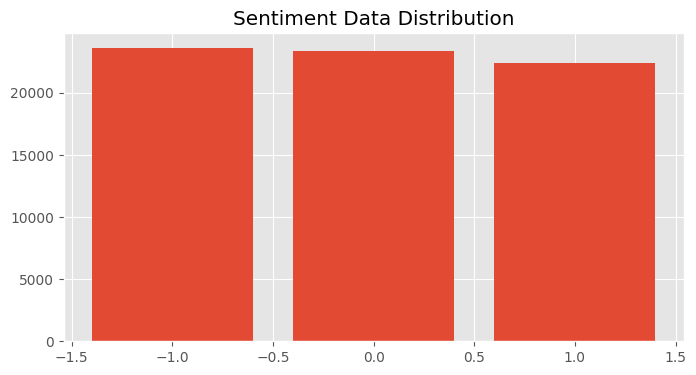

In [ ]:
val_count = df.overall.value_counts()
print(val_count)

plt.figure(figsize=(8, 4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")

In [ ]:
print('Number of rows is na: ', df.reviewText.isna().sum() + len(df[df.reviewText == ' ']))
df.dropna(inplace=True)

Number of rows is na:  1


In [ ]:
min_samples = df.overall.value_counts().min()

balanced_df = pd.DataFrame()
for sentiment in df.overall.unique():
    balanced_df = pd.concat([balanced_df, df[df.overall == sentiment].sample(n=min_samples)])

df = balanced_df.sample(frac=1).reset_index(drop=True)
df.overall.value_counts()

,count
overall,
1.0,22396
0.0,22396
-1.0,22396


overall
 1.0    22396
 0.0    22396
-1.0    22396
Name: count, dtype: int64


Text(0.5, 1.0, 'Sentiment Data Distribution')

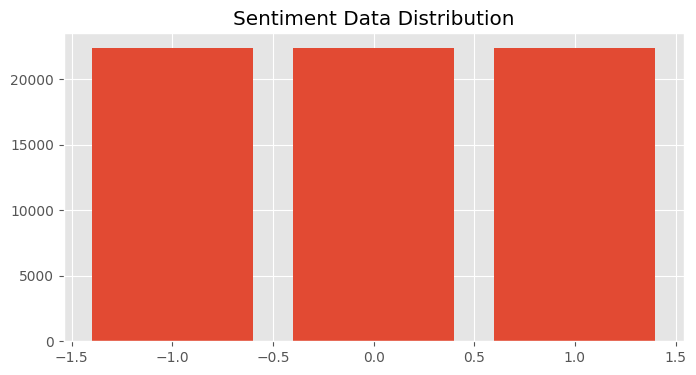

In [ ]:
val_count = df.overall.value_counts()
print(val_count)

plt.figure(figsize=(8, 4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")

0  -  5170  -  61.734491278204445


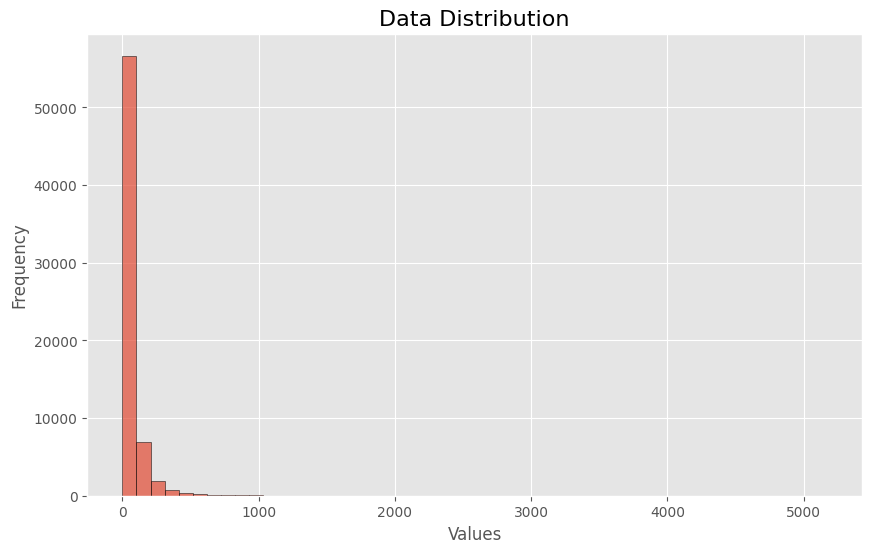

In [ ]:
review_lens = df.reviewText.map(lambda x: len(x.split()))
print(review_lens.min(), ' - ', review_lens.max(), ' - ', review_lens.mean())

plt.figure(figsize=(10, 6))
plt.hist(review_lens, bins=50, edgecolor='black', alpha=0.7)

plt.title('Data Distribution', fontsize=16)
plt.xlabel('Values', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

In [ ]:
# # positive words
# plt.figure(figsize=(10, 10))
# wc = WordCloud(max_words=2000 , width=800 , height=400).generate(" ".join(df[df.overall == 1].reviewText))
# plt.imshow(wc, interpolation='bilinear')

# # negative words
# plt.figure(figsize=(10, 10))
# wc = WordCloud(max_words=2000 , width=800 , height=400).generate(" ".join(df[df.overall == -1].reviewText))
# plt.imshow(wc, interpolation='bilinear')

# # neural words
# plt.figure(figsize=(10, 10))
# wc = WordCloud(max_words=2000 , width=800 , height=400).generate(" ".join(df[df.overall == 0].reviewText))
# plt.imshow(wc, interpolation='bilinear')

In [ ]:
# 2: neg, 1: neu, 0: pos
overall_mapping_dict = {-1: 2, 0: 1, 1: 0}
df['overall'] = df['overall'].map(overall_mapping_dict)

In [ ]:
df.to_csv(DATA_DIR + 'sampled_data_v2.csv', index=False)

# Splitting data

In [ ]:
TRAIN_SIZE = 0.7
DEV_SIZE = 0.1
TEST_SIZE = 0.2

train_df, temp_df = train_test_split(df, test_size=(1-TRAIN_SIZE), random_state=50)
dev_df, test_df = train_test_split(temp_df, test_size=(TEST_SIZE/(DEV_SIZE+TEST_SIZE)), random_state=50)

# # train
# if os.path.exists(DATA_DIR + 'train.csv'):
#     print('train.csv file found!')
#     train_df = pd.read_csv(DATA_DIR + 'train.csv')
# else:
#     print('create new train.csv!')
#     train_df.to_csv(DATA_DIR + 'train.csv', index=False)

# # dev
# if os.path.exists(DATA_DIR + 'dev.csv'):
#     print('dev.csv file found!')
#     dev_df = pd.read_csv(DATA_DIR + 'dev.csv')
# else:
#     print('create new dev.csv!')
#     dev_df.to_csv(DATA_DIR + 'dev.csv', index=False)

# # test
# if os.path.exists(DATA_DIR + 'test.csv'):
#     print('test.csv file found!')
#     test_df = pd.read_csv(DATA_DIR + 'test.csv')
# else:
#     print('create new test.csv!')
#     test_df.to_csv(DATA_DIR + 'test.csv', index=False)

train_df.shape, dev_df.shape, test_df.shape

((47031, 3), (6719, 3), (13438, 3))

# Preprocessing

In [5]:
stop_words = stopwords.words('english') # {'no', 'nor', 'not'}
stemmer = SnowballStemmer('english')
lemmatizer = WordNetLemmatizer()

def decontract(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

# converting emojis into word
def convert_emojis(text):
    for emot in UNICODE_EMOJI:
        text = text.replace(emot, ' '+"_".join(UNICODE_EMOJI[emot].replace(",","").replace(":","").split())+' ')
    return text

# converting emoticons into word
def convert_emoticons(text):
    for i,v in EMOTICONS_EMO.items():
        if i in text:
            text = text.replace(i,"_".join(v.replace(",","").split()))
            break
    return text

def preprocess(text, remove_sw, stem, lemmatize):
    text = text.lower() # lowercase

    # decontract
    text = decontract(text)

    # converting emojis and emoticons to words
    text = convert_emojis(text)
    text = convert_emoticons(text)

    # remove special characters
    text = re.sub('(<.*?>)', '', text) # remove all HTML tags
    text = re.sub(r'https?://\S+', '', text)  # remove all links
    # txt = re.sub('@[\w_]+','',txt) # remove @ references
    # txt = re.sub('#\S+','',txt) # remove # hashtags
    text = re.sub(r'[\.?!,;:\-\[\]\{\}\(\)\'\"/]', '', text) # remove all punctuations and non-ascii
    text = re.sub(r'\s+', ' ', text).strip() # remove all multiple white spaces

    # tokenization
    tokens = word_tokenize(text)

    # stopwords removal
    if remove_sw:
        tokens = [token for token in tokens if token not in stop_words]

    # steming
    if stem:
        tokens = [stemmer.stem(token) for token in tokens]

    # lemmatization
    if lemmatize:
        # tokens = [lemmatizer.lemmatize(token) for token in tokens]
        tokens = lemmatize_sentence(' '.join(tokens))

    return ' '.join(tokens)

In [ ]:
# preprocess("Best thing I've invested in in a while thank you so much 😁😁😁😁", remove_sw=True, stem=False, lemmatize=True)
# preprocess("LOVE LOVE LOVE my new and free assistant!  :) ", remove_sw=True, stem=False, lemmatize=True)

In [ ]:
# preprocessing
train_df['processedReviewText'] = train_df.reviewText.apply(lambda x: preprocess(x, remove_sw=True, stem=False, lemmatize=True))
dev_df['processedReviewText'] = dev_df.reviewText.apply(lambda x: preprocess(x, remove_sw=True, stem=False, lemmatize=True))
test_df['processedReviewText'] = test_df.reviewText.apply(lambda x: preprocess(x, remove_sw=True, stem=False, lemmatize=True))

train_df = train_df[train_df.reviewText != '']
dev_df = dev_df[dev_df.reviewText != '']
test_df = test_df[test_df.reviewText != '']

train_df.dropna(inplace=True)
dev_df.dropna(inplace=True)
test_df.dropna(inplace=True)

train_df.to_csv(DATA_DIR + 'train_processed.csv', index=False)
dev_df.to_csv(DATA_DIR + 'dev_processed.csv', index=False)
test_df.to_csv(DATA_DIR + 'test_processed.csv', index=False)

In [ ]:
# review_lens = train_df.processedReviewText.map(lambda x: len(x.split()))
# print(review_lens.min(), ' - ', review_lens.max(), ' - ', review_lens.mean())
# plt.figure(figsize=(10, 6))
# plt.hist(review_lens, bins=50, edgecolor='black', alpha=0.7)
# plt.title('Data Distribution (train_df)', fontsize=16)
# plt.xlabel('Values', fontsize=12)
# plt.ylabel('Frequency', fontsize=12)
# plt.show()

# review_lens = dev_df.processedReviewText.map(lambda x: len(x.split()))
# print(review_lens.min(), ' - ', review_lens.max(), ' - ', review_lens.mean())
# plt.figure(figsize=(10, 6))
# plt.hist(review_lens, bins=50, edgecolor='black', alpha=0.7)
# plt.title('Data Distribution (dev_df)', fontsize=16)
# plt.xlabel('Values', fontsize=12)
# plt.ylabel('Frequency', fontsize=12)
# plt.show()

# review_lens = test_df.processedReviewText.map(lambda x: len(x.split()))
# print(review_lens.min(), ' - ', review_lens.max(), ' - ', review_lens.mean())
# plt.figure(figsize=(10, 6))
# plt.hist(review_lens, bins=50, edgecolor='black', alpha=0.7)
# plt.title('Data Distribution (test_df)', fontsize=16)
# plt.xlabel('Values', fontsize=12)
# plt.ylabel('Frequency', fontsize=12)
# plt.show()

# Preprocessing industrial data

In [ ]:
with open(DATA_DIR + 'industrial_data.txt', 'r') as f:
    reviewText = f.readlines()
reviewText = [comment.strip() for comment in reviewText]
ind_df = pd.DataFrame({'reviewText': reviewText})

In [ ]:
ind_df['processedReviewText'] = ind_df.reviewText.apply(lambda x: preprocess(x, remove_sw=True, stem=False, lemmatize=True))
ind_df.to_csv(DATA_DIR + 'industrial_data_processed.csv', index=False)
ind_df.head(5)

,reviewText,processedReviewText
0,"This machine comes with everything you need. Already half assembled, if you have never assembled one before, it will take you about 1 to 2 hours. If you have experience, it will take about 30 to 45 minutes. Cuts great. I didn't use candle software that comes with the machine, but the Universal G code sender I already had installed on the computer worked great. ( FYI- I do have candle already installed on my computer and it also works great with candle.) Using machine to engrave electrical alarm panels. Does a great job for what I need.",machine come everything need already half assemble never assemble one take 1 2 hour experience take 30 45 minute cut great use candle software come machine universal g code sender already instal computer work great fyi candle already instal computer also work great candle use machine engrave electrical alarm panel great job need
1,Being newer to having our own machine this is a fun and relatively easy machine to use- some kinks with software but got it sorted and works great,new machine fun relatively easy machine use kink software get sorted work great
2,"This is my second FoxAlien product. My 4040 is an awesome machine that I use for carving, I wanted a laser setup so I ordered the 40w setup and so I did not have to change out the spindle I purchased a Masuter Pro. The only issue was the control board had problems (would not home and was failing to position) So I contacted support and they did an excellent job of diagnosing the issue and sending me a replacement controller in a timely fashion. You know you have a good company when something goes wrong and the respond quickly with replacement part or answers to question. I will for sure continue to purchase products from FoxAlien",second foxalien product 4040 awesome machine use carve want laser setup order 40w setup change spindle purchase masuter pro issue control board problem would home fail position contact support excellent job diagnose issue send replacement controller timely fashion know good company something go wrong respond quickly replacement part answer question sure continue purchase product foxalien
3,"Beginners will find this machine to be quite frustrating. Everything from setting up the included software to figuring out feeds and speeds is a black box with little to no information to help. But if you can get past that and get cutting, this thing is a little miracle at this price. The ability to turn it into a 4080, or upgrade to a 300w spindle or a laser, or add an offline controller for just a small additional investment is one of the biggest selling points for this particular machine over others.",beginner find machine quite frustrating everything set include software figure feed speed black box little information help get past get cut thing little miracle price ability turn 4080 upgrade 300w spindle laser add offline controller small additional investment one big sell point particular machine other
4,"Fox Alien definitely did there homework. This new machine is so awesome. Easy to assemble, set up, and run. The z axis is a huge upgrade previous the previous design. I would recommend upgrading to he Mikita router. It make the machine even better. It also comes with the mount for the Mikita router. For the price point you won't find a better machine. Thanks For making a great machine.",fox alien definitely homework new machine awesome easy assemble set run z axis huge upgrade previous previous design would recommend upgrading mikita router make machine even well also come mount mikita router price point find good machine thanks make great machine


In [6]:
with open(DATA_DIR + 'industrial_data_v2.txt', 'r') as f:
    reviewText = f.readlines()
reviewText = [comment.strip() for comment in reviewText]
ind_df = pd.DataFrame({'reviewText': reviewText})

In [7]:
ind_df['processedReviewText'] = ind_df.reviewText.apply(lambda x: preprocess(x, remove_sw=True, stem=False, lemmatize=True))
ind_df.to_csv(DATA_DIR + 'industrial_data_v2_processed.csv', index=False)
ind_df.head(5)

,reviewText,processedReviewText
0,"We’ve been using this CNC machine in our workshop for about a year now, and it has been fantastic. The precision it offers is unmatched, and it handles a wide variety of materials like metal and wood with ease. Even after running it for long shifts, it operates smoothly without any major hiccups. Maintenance has been minimal so far, which is a huge plus for us, as downtime can be costly. The machine’s build quality is solid, and it’s been a real asset to our production process. If you’re looking for something reliable and efficient for large-scale manufacturing, I highly recommend it.",’ use cnc machine workshop year fantastic precision offer unmatched handle wide variety material like metal wood ease even run long shifts operate smoothly without major hiccup maintenance minimal far huge plus u downtime costly machine ’ build quality solid ’ real asset production process ’ look something reliable efficient largescale manufacturing highly recommend
1,"“Honestly, I’m really disappointed with this CNC machine. We bought it for our manufacturing line, but it’s been a headache from day one. While it’s accurate when it works, it constantly breaks down during heavy use. We’ve had to replace multiple parts already, and the machine requires constant maintenance just to keep it running. This has caused major disruptions in our production schedule. To make matters worse, customer support has been incredibly slow in responding to our requests for help. For something that’s supposed to be industrial-grade, it doesn’t hold up to the demands of our business.”",“ honestly ’ really disappointed cnc machine buy manufacture line ’ headache day one ’ accurate work constantly break heavy use ’ replace multiple part already machine require constant maintenance keep run cause major disruption production schedule make matter bad customer support incredibly slow respond request help something ’ suppose industrialgrade ’ hold demand business ”


# Function to refresh data

In [ ]:
def get_data(sample=None):
    train_df = pd.read_csv(DATA_DIR + 'train_processed.csv')
    dev_df = pd.read_csv(DATA_DIR + 'dev_processed.csv')
    test_df = pd.read_csv(DATA_DIR + 'test_processed.csv')
    industrial_df = pd.read_csv(DATA_DIR + 'industrial_data_processed.csv')

    if sample:
        train_df = train_df.sample(sample[0])
        dev_df = dev_df.sample(sample[1])
        test_df = test_df.sample(sample[2])

    train_df.dropna(inplace=True)
    dev_df.dropna(inplace=True)
    test_df.dropna(inplace=True)

    X_train = train_df.processedReviewText.values
    y_train = train_df.overall.values

    X_dev = dev_df.processedReviewText.values
    y_dev = dev_df.overall.values

    X_test = test_df.processedReviewText.values
    y_test = test_df.overall.values

    X_data = np.concatenate((X_train, X_dev, X_test))
    y_data = np.concatenate((y_train, y_dev, y_test))

    print('Train data: ', X_train.shape, y_train.shape)
    print('Dev data: ', X_dev.shape, y_dev.shape)
    print('Test data: ', X_test.shape, y_test.shape)
    print('Industrial data: ', industrial_df.shape)

    return X_train, y_train, X_dev, y_dev, X_test, y_test, X_data, y_data, industrial_df

In [ ]:
X_train, y_train, X_dev, y_dev, X_test, y_test, X_data, y_data, industrial_df = get_data([20, 10, 10])

Train data:  (20,) (20,)
Dev data:  (10,) (10,)
Test data:  (10,) (10,)
Industrial data:  (63, 2)


# TFIDF + LR

## GridSearch

In [ ]:
X_train, y_train, X_dev, y_dev, _, _, _, _, _= get_data()

Train data:  (47020,) (47020,)
Dev data:  (6712,) (6712,)
Test data:  (13429,) (13429,)
Industrial data:  (63, 2)


### TFIDF

In [ ]:
# TFIDF, using unigrams, bigrams, and trigrams
def split_func(x):
    return x.split()
tfidf_vectorizer = TfidfVectorizer(max_features=12000, sublinear_tf=True, norm='l2', ngram_range=(1, 3))
tfidf_vectorizer.tokenizer = split_func

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_dev_tfidf = tfidf_vectorizer.transform(X_dev)

X_train_tfidf.shape, X_dev_tfidf.shape

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


((47020, 12000), (6712, 12000))

### LR

In [ ]:
# dt = DecisionTreeClassifier()
# lr = LogisticRegression()
# svc = SVC()
# rf = RandomForestClassifier()
# nb = BernoulliNB()
# knn = KNeighborsClassifier()

# ml_models = [dt, lr, svc, rf, nb, knn]
# ml_models_dict = {
#     0: "Decision Tree",
#     1: "Logistic Regression",
#     2: "SVC",
#     3: "Random Forest",
#     4: "Naive Bayes",
#     5: "KNN"
# }

# for i, model in enumerate(ml_models):
#     # # train-test
#     # model.fit(X_train_tfidf, y_train)
#     # y_val_pred = model.predict(X_val_tfidf)
#     # print(f'{ml_models_dict[i]}, Accuracy: ', accuracy_score(y_val_pred, y_val.values))

#     # cross validation
#     scores = cross_val_score(model, X_train_tfidf, y_train, cv=10, scoring='accuracy')
#     print(f'{ml_models_dict[i]}, Mean Acc: {scores.mean():.4f}, Std: {scores.std():.4f}')

In [ ]:
def grid_search_ml(model, params):
    best_score = 0
    best_params = None
    best_estimator = None
    all_results = []

    for C in params['C']:
        for penalty in params['penalty']:
            for solver in params['solver']:
                for max_iter in params['max_iter']:
                    print({'C': C, 'penalty': penalty, 'solver': solver, 'max_iter': max_iter})
                    model.set_params(C=C, penalty=penalty, solver=solver, max_iter=max_iter)
                    model.fit(X_train_tfidf, y_train)
                    y_pred = model.predict(X_dev_tfidf)
                    score = accuracy_score(y_dev, y_pred)
                    all_results.append({'C': C, 'penalty': penalty, 'solver': solver, 'max_iter': max_iter, 'score': score})
                    if score > best_score:
                        best_score = score
                        best_params = {'C': C, 'penalty': penalty, 'solver': solver, 'max_iter': max_iter}

    print("Best parameters:", best_params)
    print("Best score on test set:", best_score)

    return all_results

In [ ]:
lr_params = {
    'C': [1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 200]
}
results = grid_search_ml(LogisticRegression(random_state=42), lr_params)

{'C': 1, 'penalty': 'l1', 'solver': 'liblinear', 'max_iter': 100}
{'C': 1, 'penalty': 'l1', 'solver': 'liblinear', 'max_iter': 200}
{'C': 1, 'penalty': 'l1', 'solver': 'saga', 'max_iter': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


{'C': 1, 'penalty': 'l1', 'solver': 'saga', 'max_iter': 200}
{'C': 1, 'penalty': 'l2', 'solver': 'liblinear', 'max_iter': 100}
{'C': 1, 'penalty': 'l2', 'solver': 'liblinear', 'max_iter': 200}
{'C': 1, 'penalty': 'l2', 'solver': 'saga', 'max_iter': 100}
{'C': 1, 'penalty': 'l2', 'solver': 'saga', 'max_iter': 200}
{'C': 10, 'penalty': 'l1', 'solver': 'liblinear', 'max_iter': 100}
{'C': 10, 'penalty': 'l1', 'solver': 'liblinear', 'max_iter': 200}
{'C': 10, 'penalty': 'l1', 'solver': 'saga', 'max_iter': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


{'C': 10, 'penalty': 'l1', 'solver': 'saga', 'max_iter': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


{'C': 10, 'penalty': 'l2', 'solver': 'liblinear', 'max_iter': 100}
{'C': 10, 'penalty': 'l2', 'solver': 'liblinear', 'max_iter': 200}
{'C': 10, 'penalty': 'l2', 'solver': 'saga', 'max_iter': 100}
{'C': 10, 'penalty': 'l2', 'solver': 'saga', 'max_iter': 200}
Best parameters: {'C': 1, 'penalty': 'l1', 'solver': 'saga', 'max_iter': 100}
Best score on test set: 0.6927890345649583


In [ ]:
pd.DataFrame(results)

,C,penalty,solver,max_iter,score
0,1,l1,liblinear,100,0.691746
1,1,l1,liblinear,200,0.691746
2,1,l1,saga,100,0.692789
3,1,l1,saga,200,0.692789
4,1,l2,liblinear,100,0.691150
5,1,l2,liblinear,200,0.691150
6,1,l2,saga,100,0.688319
7,1,l2,saga,200,0.688319
8,10,l1,liblinear,100,0.653456
9,10,l1,liblinear,200,0.653456


## Retrain the best model

In [ ]:
X_train, y_train, X_dev, y_dev, X_test, y_test, _, _, _= get_data()

Train data:  (47020,) (47020,)
Dev data:  (6712,) (6712,)
Test data:  (13429,) (13429,)
Industrial data:  (63, 2)


### TFIDF

In [ ]:
X_train = np.concatenate((X_train, X_dev))
y_train = np.concatenate((y_train, y_dev))

# TFIDF, using unigrams, bigrams, and trigrams
def split_func(x):
    return x.split()
tfidf_vectorizer = TfidfVectorizer(max_features=12000, sublinear_tf=True, norm='l2', ngram_range=(1, 3))
tfidf_vectorizer.tokenizer = split_func

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

joblib.dump(tfidf_vectorizer, MODEL_DIR + 'lr/tfidf_vectorizer.joblib')
tfidf_vectorizer = joblib.load(MODEL_DIR + 'lr/tfidf_vectorizer.joblib')

X_train_tfidf.shape, X_test_tfidf.shape

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


((53732, 12000), (13429, 12000))

### The best LR

In [ ]:
# best params: 1 - l1 - saga - 100
best_lr_model = LogisticRegression(random_state=42, C=1, max_iter=100, penalty='l1', solver='saga')
best_lr_model.fit(X_train_tfidf, y_train)
joblib.dump(best_lr_model, MODEL_DIR + 'lr/lr_best.joblib')
best_lr_model

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(C=1, penalty='l1', random_state=42, solver='saga')

## Evaluation on test set

In [ ]:
X_train, y_train, X_dev, y_dev, X_test, y_test, _, _, _= get_data()

Train data:  (47020,) (47020,)
Dev data:  (6712,) (6712,)
Test data:  (13429,) (13429,)
Industrial data:  (63, 2)


In [ ]:
best_lr_model = joblib.load(MODEL_DIR + 'lr/lr_best.joblib')
def split_func(x):
    return x.split()
tfidf_vectorizer = joblib.load(MODEL_DIR + 'lr/tfidf_vectorizer.joblib')
tfidf_vectorizer.tokenizer = split_func

In [ ]:
# X_train = np.concatenate((X_train, X_dev))
# y_train = np.concatenate((y_train, y_dev))
# X_train_tfidf = tfidf_vectorizer.transform(X_train)

X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [ ]:
# y_pred = best_lr_model.predict(X_train_tfidf)
# accuracy = accuracy_score(y_train, y_pred)
# f1 = f1_score(y_train, y_pred, average='macro')
# y_prob = best_lr_model.predict_proba(X_train_tfidf)
# train_log_loss = log_loss(y_train, y_prob)

# print(f"Accuracy on train set: {accuracy:.4f}")
# print(f"F1-score on train set: {f1:.4f}")
# print(f"Log Loss on train set: {train_log_loss:.4f}")

y_pred = best_lr_model.predict(X_test_tfidf)
y_prob = best_lr_model.predict_proba(X_test_tfidf)

test_log_loss = log_loss(y_test, y_prob)
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='macro')
precision = precision_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Log Loss on test set: {test_log_loss:.4f}")
print(f"Accuracy on test set: {accuracy:.4f}")
print(f"Recall on test set: {recall:.4f}")
print(f"Precision on test set: {precision:.4f}")
print(f"F1-score on test set: {f1:.4f}")

Log Loss on test set: 0.7135
Accuracy on test set: 0.6824
Recall on test set: 0.6824
Precision on test set: 0.6810
F1-score on test set: 0.6815


In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive', 'Neutral', 'Negative'], yticklabels=['Positive', 'Neutral', 'Negative'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('')
plt.savefig(IMAGE_DIR + 'lr_cm.png', dpi=300, bbox_inches='tight')
plt.show()

# Word2Vec + LSTM

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## GridSearch

In [ ]:
X_train, y_train, X_dev, y_dev, X_test, y_test, _, _, _= get_data()

Train data:  (47020,) (47020,)
Dev data:  (6712,) (6712,)
Test data:  (13429,) (13429,)
Industrial data:  (63, 2)


### Texts to sequences

In [ ]:
def text_to_sequence(X_train, X_test, max_length=60):
    tokenizer = Tokenizer()

    tokenizer.fit_on_texts(X_train)
    X_train_seq = tokenizer.texts_to_sequences(X_train)
    X_test_seq = tokenizer.texts_to_sequences(X_test)

    X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
    X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

    # convert to pytorch tensor
    X_train_pad_tensor = torch.FloatTensor(X_train_pad).unsqueeze(2)
    X_test_pad_tensor = torch.FloatTensor(X_test_pad).unsqueeze(2)

    return X_train_pad_tensor, X_test_pad_tensor, tokenizer

X_train_pad, X_dev_pad, tokenizer = text_to_sequence(X_train, X_dev)
X_train_pad.shape, X_dev_pad.shape

(torch.Size([53732, 70, 1]), torch.Size([6712, 70, 1]))

### Creating embedding matrix

In [ ]:
word2vec_model_name = 'word2vec-google-news-300'
word2vec_model_path = MODEL_DIR + 'lstm/' + word2vec_model_name + '.pickle'
if os.path.exists(word2vec_model_path):
    print('Loading')
    with open(word2vec_model_path, 'rb') as handle:
        word2vec_model = pickle.load(handle)
else:
    print('Creating')
    word2vec_model = api.load('word2vec-google-news-300')
    with open(word2vec_model_path, 'wb') as handle:
        pickle.dump(word2vec_model, handle, protocol=pickle.HIGHEST_PROTOCOL)

Loading


In [ ]:
def get_embedding_matrix(vocab_size, embed_dim, tokenizer):
    embedding_matrix = np.zeros((vocab_size, embed_dim))
    for word, i in tokenizer.word_index.items():
        try:
            embedding_vector = word2vec_model[word]
            embedding_matrix[i] = embedding_vector
        except KeyError:
            pass

    return embedding_matrix

In [ ]:
vocabulary_size = len(tokenizer.word_index) + 1
embedding_dim = 300
embedding_matrix = get_embedding_matrix(vocabulary_size, embedding_dim, tokenizer)
embedding_matrix.shape

### Onehot y

In [ ]:
def get_onehot_y(y_train, y_test):
    encoder = OneHotEncoder(sparse_output=False)
    y_train_onehot_tensor = torch.FloatTensor(encoder.fit_transform(y_train.reshape(-1, 1)))
    y_test_onehot_tensor = torch.FloatTensor(encoder.fit_transform(y_test.reshape(-1, 1)))
    return y_train_onehot_tensor,  y_test_onehot_tensor

In [ ]:
# onehot y
y_train_onehot, y_dev_onehot = get_onehot_y(y_train, y_dev)
y_train_onehot.shape, y_dev_onehot.shape

### Data loader

In [ ]:
def get_data_loader(X_train, X_test, y_train, y_test, batch_size=32):
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

In [ ]:
train_loader, dev_loader = get_data_loader(X_train_pad, X_dev_pad, y_train_onehot, y_dev_onehot, batch_size=64)

### Define model & training loop

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, embedding_dim, embedding_matrix, num_classes=3, hidden_size=[64, 128], activation='relu'):

        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), freeze=True)  # Freeze embeddings

        self.lstm1 = nn.LSTM(embedding_dim, hidden_size[0], batch_first=True)
        self.dropout1 = nn.Dropout(0.5)
        self.lstm2 = nn.LSTM(hidden_size[0], hidden_size[1], batch_first=True)
        self.dropout2 = nn.Dropout(0.5)

        self.fc1 = nn.Linear(hidden_size[1], 64)
        self.dropout3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, num_classes)

        self.batch_norm1 = nn.BatchNorm1d(64)
        self.batch_norm2 = nn.BatchNorm1d(32)

        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'tanh':
            self.activation = nn.Tanh()
        elif activation == 'sigmoid':
            self.activation = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x.long().squeeze(-1))
        x, _ = self.lstm1(x)
        x = self.dropout1(x)
        x, _ = self.lstm2(x)
        x = self.dropout2(x)
        x = x[:, -1, :]  # last step

        x = self.activation(self.batch_norm1(self.fc1(x)))
        x = self.dropout3(x)
        x = self.activation(self.batch_norm2(self.fc2(x)))
        x = self.fc3(x)
        return x

In [ ]:
def train_function(model, epochs, train_loader, criterion, optimizer, device):
    for epoch in range(epochs):
        # training
        model.train()
        train_loss = 0
        all_predictions = []
        all_true_labels = []

        for batch_X, batch_y in tqdm(train_loader):
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            _, true_labels = torch.max(batch_y.data, 1)

            all_predictions.append(predicted.cpu().numpy())
            all_true_labels.append(true_labels.cpu().numpy())

        train_loss /= len(train_loader)
        all_predictions = np.concatenate(all_predictions)
        all_true_labels = np.concatenate(all_true_labels)
        train_accuracy = accuracy_score(all_true_labels, all_predictions) * 100
        train_f1 = f1_score(all_true_labels, all_predictions, average='weighted')

        print(f'Epoch {epoch+1} / {epochs} | Loss: {train_loss:.4f} | Accuracy: {train_accuracy:.2f} | F1 Score: {train_f1:.4f}')

    return model

def score_function(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0
    all_predictions = []
    all_true_labels = []
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)

            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            _, true_labels = torch.max(batch_y.data, 1)

            all_predictions.append(predicted.cpu().numpy())
            all_true_labels.append(true_labels.cpu().numpy())

    test_loss /= len(test_loader)

    # acc, f1, precision, recall
    all_predictions = np.concatenate(all_predictions)
    all_true_labels = np.concatenate(all_true_labels)
    test_accuracy = accuracy_score(all_true_labels, all_predictions)
    test_f1 = f1_score(all_true_labels, all_predictions, average='macro')
    test_precision = precision_score(all_true_labels, all_predictions, average='macro')
    test_recall = recall_score(all_true_labels, all_predictions, average='macro')

    print(f'Validation | Loss: {test_loss:.4f} | Accuracy: {test_accuracy:.2f} | F1-score: {test_f1:.4f} | Precision: {test_precision:.4f} | Recall: {test_recall:.4f}')

    return all_predictions, all_true_labels, test_accuracy, test_loss, test_f1, test_precision, test_recall

### GridSearch LSTM

In [ ]:
num_classes = 3
input_size = 1
lr = 0.0001
batch_size = 64
epochs = 30

hidden_size_1 =  [64, 128]
hidden_size_2 = [64, 128]
activation_function = ['sigmoid', 'tanh', 'relu']

all_params_combs = list(product(hidden_size_1, hidden_size_2, activation_function))
all_params_combs

[(64, 64, 'sigmoid'),
 (64, 64, 'tanh'),
 (64, 64, 'relu'),
 (64, 128, 'sigmoid'),
 (64, 128, 'tanh'),
 (64, 128, 'relu'),
 (128, 64, 'sigmoid'),
 (128, 64, 'tanh'),
 (128, 64, 'relu'),
 (128, 128, 'sigmoid'),
 (128, 128, 'tanh'),
 (128, 128, 'relu')]

In [ ]:
scores_list = []
params_list = []

In [ ]:
for params in all_params_combs:
    print(params)
    hidden_size = [params[0], params[1]]
    activation = params[2]

    # model
    model = LSTMModel(embedding_dim=embedding_dim,
                      embedding_matrix=embedding_matrix,
                      hidden_size=hidden_size,
                      activation=activation).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    trained_model = train_function(model, epochs, train_loader, criterion, optimizer, device)
    score = score_function(trained_model, dev_loader, criterion, device)

    scores_list.append(score)
    params_list.append([p for p in params])

    del model
    print()

(64, 64, 'sigmoid')


100%|██████████| 735/735 [00:11<00:00, 63.53it/s]


Epoch 1 / 30 | Loss: 1.1053 | Accuracy: 33.61 | F1 Score: 0.3285


100%|██████████| 735/735 [00:14<00:00, 51.24it/s] 


Epoch 2 / 30 | Loss: 1.1003 | Accuracy: 33.83 | F1 Score: 0.3383


100%|██████████| 735/735 [00:04<00:00, 148.33it/s]


Epoch 3 / 30 | Loss: 1.0970 | Accuracy: 34.73 | F1 Score: 0.3441


100%|██████████| 735/735 [00:05<00:00, 124.20it/s]


Epoch 4 / 30 | Loss: 1.0044 | Accuracy: 51.33 | F1 Score: 0.4754


100%|██████████| 735/735 [00:05<00:00, 143.62it/s]


Epoch 5 / 30 | Loss: 0.9125 | Accuracy: 56.45 | F1 Score: 0.5369


100%|██████████| 735/735 [00:03<00:00, 196.84it/s]


Epoch 6 / 30 | Loss: 0.8781 | Accuracy: 58.09 | F1 Score: 0.5624


100%|██████████| 735/735 [00:04<00:00, 166.59it/s]


Epoch 7 / 30 | Loss: 0.8584 | Accuracy: 59.17 | F1 Score: 0.5808


100%|██████████| 735/735 [00:04<00:00, 172.36it/s]


Epoch 8 / 30 | Loss: 0.8485 | Accuracy: 59.87 | F1 Score: 0.5903


100%|██████████| 735/735 [00:03<00:00, 198.69it/s]


Epoch 9 / 30 | Loss: 0.8386 | Accuracy: 60.44 | F1 Score: 0.5982


100%|██████████| 735/735 [00:03<00:00, 192.98it/s]


Epoch 10 / 30 | Loss: 0.8317 | Accuracy: 60.64 | F1 Score: 0.6019


100%|██████████| 735/735 [00:04<00:00, 150.99it/s]


Epoch 11 / 30 | Loss: 0.8223 | Accuracy: 61.12 | F1 Score: 0.6069


100%|██████████| 735/735 [00:04<00:00, 181.57it/s]


Epoch 12 / 30 | Loss: 0.8159 | Accuracy: 61.80 | F1 Score: 0.6156


100%|██████████| 735/735 [00:05<00:00, 126.71it/s]


Epoch 13 / 30 | Loss: 0.8090 | Accuracy: 62.12 | F1 Score: 0.6197


100%|██████████| 735/735 [00:07<00:00, 92.55it/s]


Epoch 14 / 30 | Loss: 0.8027 | Accuracy: 62.69 | F1 Score: 0.6257


100%|██████████| 735/735 [00:08<00:00, 91.66it/s]


Epoch 15 / 30 | Loss: 0.7952 | Accuracy: 63.22 | F1 Score: 0.6313


100%|██████████| 735/735 [00:09<00:00, 81.42it/s]


Epoch 16 / 30 | Loss: 0.7913 | Accuracy: 63.52 | F1 Score: 0.6347


100%|██████████| 735/735 [00:08<00:00, 90.89it/s]


Epoch 17 / 30 | Loss: 0.7838 | Accuracy: 64.02 | F1 Score: 0.6400


100%|██████████| 735/735 [00:04<00:00, 155.88it/s]


Epoch 18 / 30 | Loss: 0.7787 | Accuracy: 64.30 | F1 Score: 0.6431


100%|██████████| 735/735 [00:03<00:00, 196.61it/s]


Epoch 19 / 30 | Loss: 0.7729 | Accuracy: 64.68 | F1 Score: 0.6472


100%|██████████| 735/735 [00:04<00:00, 180.20it/s]


Epoch 20 / 30 | Loss: 0.7663 | Accuracy: 65.13 | F1 Score: 0.6519


100%|██████████| 735/735 [00:04<00:00, 154.99it/s]


Epoch 21 / 30 | Loss: 0.7635 | Accuracy: 65.36 | F1 Score: 0.6546


100%|██████████| 735/735 [00:03<00:00, 195.11it/s]


Epoch 22 / 30 | Loss: 0.7597 | Accuracy: 65.63 | F1 Score: 0.6574


100%|██████████| 735/735 [00:03<00:00, 198.19it/s]


Epoch 23 / 30 | Loss: 0.7569 | Accuracy: 65.66 | F1 Score: 0.6579


100%|██████████| 735/735 [00:05<00:00, 145.32it/s]


Epoch 24 / 30 | Loss: 0.7537 | Accuracy: 65.90 | F1 Score: 0.6606


100%|██████████| 735/735 [00:03<00:00, 192.86it/s]


Epoch 25 / 30 | Loss: 0.7499 | Accuracy: 66.05 | F1 Score: 0.6623


100%|██████████| 735/735 [00:03<00:00, 198.56it/s]


Epoch 26 / 30 | Loss: 0.7466 | Accuracy: 66.21 | F1 Score: 0.6638


100%|██████████| 735/735 [00:04<00:00, 177.30it/s]


Epoch 27 / 30 | Loss: 0.7444 | Accuracy: 66.41 | F1 Score: 0.6661


100%|██████████| 735/735 [00:04<00:00, 160.15it/s]


Epoch 28 / 30 | Loss: 0.7389 | Accuracy: 67.14 | F1 Score: 0.6734


100%|██████████| 735/735 [00:03<00:00, 198.78it/s]


Epoch 29 / 30 | Loss: 0.7338 | Accuracy: 67.19 | F1 Score: 0.6742


100%|██████████| 735/735 [00:03<00:00, 199.68it/s]


Epoch 30 / 30 | Loss: 0.7343 | Accuracy: 67.15 | F1 Score: 0.6737
Validation | Loss: 0.7385 | Accuracy: 66.57 | F1 Score: 0.6693

(64, 64, 'tanh')


100%|██████████| 735/735 [00:05<00:00, 143.84it/s]


Epoch 1 / 30 | Loss: 1.1236 | Accuracy: 33.92 | F1 Score: 0.3279


100%|██████████| 735/735 [00:03<00:00, 200.03it/s]


Epoch 2 / 30 | Loss: 1.1052 | Accuracy: 34.15 | F1 Score: 0.3321


100%|██████████| 735/735 [00:03<00:00, 197.38it/s]


Epoch 3 / 30 | Loss: 1.1015 | Accuracy: 34.08 | F1 Score: 0.3350


100%|██████████| 735/735 [00:04<00:00, 173.95it/s]


Epoch 4 / 30 | Loss: 1.1002 | Accuracy: 34.07 | F1 Score: 0.3370


100%|██████████| 735/735 [00:04<00:00, 165.19it/s]


Epoch 5 / 30 | Loss: 1.0979 | Accuracy: 34.69 | F1 Score: 0.3428


100%|██████████| 735/735 [00:03<00:00, 189.75it/s]


Epoch 6 / 30 | Loss: 1.0855 | Accuracy: 37.07 | F1 Score: 0.3612


100%|██████████| 735/735 [00:04<00:00, 168.94it/s]


Epoch 7 / 30 | Loss: 1.0445 | Accuracy: 43.53 | F1 Score: 0.4138


100%|██████████| 735/735 [00:07<00:00, 103.92it/s]


Epoch 8 / 30 | Loss: 1.0332 | Accuracy: 47.11 | F1 Score: 0.4117


100%|██████████| 735/735 [00:04<00:00, 157.16it/s]


Epoch 9 / 30 | Loss: 1.0303 | Accuracy: 44.68 | F1 Score: 0.4292


100%|██████████| 735/735 [00:07<00:00, 98.47it/s]


Epoch 10 / 30 | Loss: 1.0437 | Accuracy: 46.34 | F1 Score: 0.3877


100%|██████████| 735/735 [00:07<00:00, 96.10it/s]


Epoch 11 / 30 | Loss: 1.0172 | Accuracy: 47.84 | F1 Score: 0.4262


100%|██████████| 735/735 [00:05<00:00, 134.80it/s]


Epoch 12 / 30 | Loss: 1.0105 | Accuracy: 47.67 | F1 Score: 0.4381


100%|██████████| 735/735 [00:04<00:00, 179.89it/s]


Epoch 13 / 30 | Loss: 1.0084 | Accuracy: 47.69 | F1 Score: 0.4373


100%|██████████| 735/735 [00:03<00:00, 186.67it/s]


Epoch 14 / 30 | Loss: 0.9995 | Accuracy: 48.39 | F1 Score: 0.4430


100%|██████████| 735/735 [00:05<00:00, 125.54it/s]


Epoch 15 / 30 | Loss: 0.9935 | Accuracy: 49.03 | F1 Score: 0.4459


100%|██████████| 735/735 [00:06<00:00, 106.53it/s]


Epoch 16 / 30 | Loss: 0.9859 | Accuracy: 49.24 | F1 Score: 0.4602


100%|██████████| 735/735 [00:04<00:00, 154.25it/s]


Epoch 17 / 30 | Loss: 0.9723 | Accuracy: 50.56 | F1 Score: 0.4643


100%|██████████| 735/735 [00:05<00:00, 146.92it/s]


Epoch 18 / 30 | Loss: 0.9494 | Accuracy: 53.07 | F1 Score: 0.4905


100%|██████████| 735/735 [00:04<00:00, 148.55it/s]


Epoch 19 / 30 | Loss: 0.9288 | Accuracy: 54.46 | F1 Score: 0.5152


100%|██████████| 735/735 [00:08<00:00, 85.21it/s]


Epoch 20 / 30 | Loss: 0.9162 | Accuracy: 55.35 | F1 Score: 0.5353


100%|██████████| 735/735 [00:05<00:00, 137.08it/s]


Epoch 21 / 30 | Loss: 0.9018 | Accuracy: 56.30 | F1 Score: 0.5539


100%|██████████| 735/735 [00:06<00:00, 120.83it/s]


Epoch 22 / 30 | Loss: 0.8962 | Accuracy: 57.14 | F1 Score: 0.5678


100%|██████████| 735/735 [00:05<00:00, 134.88it/s]


Epoch 23 / 30 | Loss: 0.8880 | Accuracy: 57.19 | F1 Score: 0.5675


100%|██████████| 735/735 [00:05<00:00, 140.42it/s]


Epoch 24 / 30 | Loss: 0.8775 | Accuracy: 57.49 | F1 Score: 0.5717


100%|██████████| 735/735 [00:08<00:00, 87.33it/s]


Epoch 25 / 30 | Loss: 0.8672 | Accuracy: 58.29 | F1 Score: 0.5789


100%|██████████| 735/735 [00:06<00:00, 112.80it/s]


Epoch 26 / 30 | Loss: 0.8563 | Accuracy: 59.00 | F1 Score: 0.5897


100%|██████████| 735/735 [00:09<00:00, 81.51it/s]


Epoch 27 / 30 | Loss: 0.8523 | Accuracy: 59.80 | F1 Score: 0.5990


100%|██████████| 735/735 [00:07<00:00, 92.30it/s] 


Epoch 28 / 30 | Loss: 0.8420 | Accuracy: 59.99 | F1 Score: 0.6004


100%|██████████| 735/735 [00:07<00:00, 95.59it/s] 


Epoch 29 / 30 | Loss: 0.8353 | Accuracy: 60.61 | F1 Score: 0.6077


100%|██████████| 735/735 [00:07<00:00, 104.61it/s]


Epoch 30 / 30 | Loss: 0.8290 | Accuracy: 60.80 | F1 Score: 0.6086
Validation | Loss: 0.8023 | Accuracy: 62.11 | F1 Score: 0.6218

(64, 64, 'relu')


100%|██████████| 735/735 [00:07<00:00, 96.01it/s] 


Epoch 1 / 30 | Loss: 1.1557 | Accuracy: 33.38 | F1 Score: 0.2867


100%|██████████| 735/735 [00:05<00:00, 140.06it/s]


Epoch 2 / 30 | Loss: 1.1097 | Accuracy: 33.66 | F1 Score: 0.3338


100%|██████████| 735/735 [00:05<00:00, 137.10it/s]


Epoch 3 / 30 | Loss: 1.1050 | Accuracy: 33.64 | F1 Score: 0.3350


100%|██████████| 735/735 [00:07<00:00, 100.93it/s]


Epoch 4 / 30 | Loss: 1.1004 | Accuracy: 34.10 | F1 Score: 0.3374


100%|██████████| 735/735 [00:06<00:00, 105.74it/s]


Epoch 5 / 30 | Loss: 1.0960 | Accuracy: 35.10 | F1 Score: 0.3424


100%|██████████| 735/735 [00:08<00:00, 87.57it/s] 


Epoch 6 / 30 | Loss: 1.0823 | Accuracy: 39.55 | F1 Score: 0.3910


100%|██████████| 735/735 [00:05<00:00, 123.06it/s]


Epoch 7 / 30 | Loss: 1.0671 | Accuracy: 39.92 | F1 Score: 0.3975


100%|██████████| 735/735 [00:05<00:00, 130.57it/s]


Epoch 8 / 30 | Loss: 1.0542 | Accuracy: 41.04 | F1 Score: 0.4099


100%|██████████| 735/735 [00:03<00:00, 195.68it/s]


Epoch 9 / 30 | Loss: 1.0378 | Accuracy: 42.83 | F1 Score: 0.4231


100%|██████████| 735/735 [00:03<00:00, 196.89it/s]


Epoch 10 / 30 | Loss: 1.0315 | Accuracy: 44.20 | F1 Score: 0.4320


100%|██████████| 735/735 [00:04<00:00, 156.63it/s]


Epoch 11 / 30 | Loss: 1.0353 | Accuracy: 42.08 | F1 Score: 0.4113


100%|██████████| 735/735 [00:04<00:00, 181.89it/s]


Epoch 12 / 30 | Loss: 1.0357 | Accuracy: 42.90 | F1 Score: 0.4103


100%|██████████| 735/735 [00:03<00:00, 195.30it/s]


Epoch 13 / 30 | Loss: 1.0432 | Accuracy: 43.45 | F1 Score: 0.4168


100%|██████████| 735/735 [00:05<00:00, 126.84it/s]


Epoch 14 / 30 | Loss: 1.0444 | Accuracy: 46.89 | F1 Score: 0.3812


100%|██████████| 735/735 [00:04<00:00, 158.27it/s]


Epoch 15 / 30 | Loss: 1.0417 | Accuracy: 47.11 | F1 Score: 0.3785


100%|██████████| 735/735 [00:03<00:00, 193.29it/s]


Epoch 16 / 30 | Loss: 1.0564 | Accuracy: 44.34 | F1 Score: 0.3716


100%|██████████| 735/735 [00:03<00:00, 192.89it/s]


Epoch 17 / 30 | Loss: 1.0630 | Accuracy: 43.50 | F1 Score: 0.3494


100%|██████████| 735/735 [00:04<00:00, 151.83it/s]


Epoch 18 / 30 | Loss: 1.0619 | Accuracy: 43.58 | F1 Score: 0.3456


100%|██████████| 735/735 [00:03<00:00, 196.04it/s]


Epoch 19 / 30 | Loss: 1.0579 | Accuracy: 44.41 | F1 Score: 0.3527


100%|██████████| 735/735 [00:03<00:00, 197.06it/s]


Epoch 20 / 30 | Loss: 1.0571 | Accuracy: 44.49 | F1 Score: 0.3531


100%|██████████| 735/735 [00:04<00:00, 147.82it/s]


Epoch 21 / 30 | Loss: 1.0571 | Accuracy: 44.54 | F1 Score: 0.3537


100%|██████████| 735/735 [00:03<00:00, 191.75it/s]


Epoch 22 / 30 | Loss: 1.0541 | Accuracy: 45.14 | F1 Score: 0.3597


100%|██████████| 735/735 [00:03<00:00, 195.12it/s]


Epoch 23 / 30 | Loss: 1.0508 | Accuracy: 45.74 | F1 Score: 0.3649


100%|██████████| 735/735 [00:04<00:00, 174.05it/s]


Epoch 24 / 30 | Loss: 1.0520 | Accuracy: 45.51 | F1 Score: 0.3637


100%|██████████| 735/735 [00:04<00:00, 162.01it/s]


Epoch 25 / 30 | Loss: 1.0570 | Accuracy: 44.55 | F1 Score: 0.3643


100%|██████████| 735/735 [00:03<00:00, 197.63it/s]


Epoch 26 / 30 | Loss: 1.0702 | Accuracy: 41.61 | F1 Score: 0.3651


100%|██████████| 735/735 [00:04<00:00, 153.81it/s]


Epoch 27 / 30 | Loss: 1.0857 | Accuracy: 38.06 | F1 Score: 0.3499


100%|██████████| 735/735 [00:07<00:00, 98.39it/s] 


Epoch 28 / 30 | Loss: 1.0651 | Accuracy: 42.55 | F1 Score: 0.3898


100%|██████████| 735/735 [00:03<00:00, 198.86it/s]


Epoch 29 / 30 | Loss: 1.0469 | Accuracy: 42.22 | F1 Score: 0.4129


100%|██████████| 735/735 [00:04<00:00, 174.82it/s]


Epoch 30 / 30 | Loss: 1.0359 | Accuracy: 43.45 | F1 Score: 0.4351
Validation | Loss: 1.0297 | Accuracy: 44.35 | F1 Score: 0.4327

(64, 128, 'sigmoid')


100%|██████████| 735/735 [00:04<00:00, 169.21it/s]


Epoch 1 / 30 | Loss: 1.1028 | Accuracy: 33.64 | F1 Score: 0.3289


100%|██████████| 735/735 [00:03<00:00, 196.85it/s]


Epoch 2 / 30 | Loss: 1.0952 | Accuracy: 35.72 | F1 Score: 0.3553


100%|██████████| 735/735 [00:03<00:00, 193.86it/s]


Epoch 3 / 30 | Loss: 1.0145 | Accuracy: 50.33 | F1 Score: 0.4632


100%|██████████| 735/735 [00:04<00:00, 148.45it/s]


Epoch 4 / 30 | Loss: 0.9238 | Accuracy: 55.67 | F1 Score: 0.5169


100%|██████████| 735/735 [00:03<00:00, 197.01it/s]


Epoch 5 / 30 | Loss: 0.8858 | Accuracy: 57.51 | F1 Score: 0.5504


100%|██████████| 735/735 [00:03<00:00, 194.48it/s]


Epoch 6 / 30 | Loss: 0.8634 | Accuracy: 58.48 | F1 Score: 0.5666


100%|██████████| 735/735 [00:04<00:00, 151.66it/s]


Epoch 7 / 30 | Loss: 0.8498 | Accuracy: 59.46 | F1 Score: 0.5807


100%|██████████| 735/735 [00:03<00:00, 191.43it/s]


Epoch 8 / 30 | Loss: 0.8417 | Accuracy: 60.22 | F1 Score: 0.5927


100%|██████████| 735/735 [00:03<00:00, 196.23it/s]


Epoch 9 / 30 | Loss: 0.8300 | Accuracy: 60.88 | F1 Score: 0.6020


100%|██████████| 735/735 [00:04<00:00, 175.26it/s]


Epoch 10 / 30 | Loss: 0.8232 | Accuracy: 61.10 | F1 Score: 0.6062


100%|██████████| 735/735 [00:04<00:00, 160.18it/s]


Epoch 11 / 30 | Loss: 0.8154 | Accuracy: 61.88 | F1 Score: 0.6155


100%|██████████| 735/735 [00:03<00:00, 198.39it/s]


Epoch 12 / 30 | Loss: 0.8055 | Accuracy: 62.44 | F1 Score: 0.6226


100%|██████████| 735/735 [00:03<00:00, 198.09it/s]


Epoch 13 / 30 | Loss: 0.7998 | Accuracy: 62.87 | F1 Score: 0.6276


100%|██████████| 735/735 [00:05<00:00, 145.75it/s]


Epoch 14 / 30 | Loss: 0.7933 | Accuracy: 63.20 | F1 Score: 0.6314


100%|██████████| 735/735 [00:03<00:00, 197.17it/s]


Epoch 15 / 30 | Loss: 0.7851 | Accuracy: 63.76 | F1 Score: 0.6374


100%|██████████| 735/735 [00:03<00:00, 198.17it/s]


Epoch 16 / 30 | Loss: 0.7802 | Accuracy: 63.96 | F1 Score: 0.6397


100%|██████████| 735/735 [00:04<00:00, 169.61it/s]


Epoch 17 / 30 | Loss: 0.7744 | Accuracy: 64.34 | F1 Score: 0.6438


100%|██████████| 735/735 [00:04<00:00, 158.87it/s]


Epoch 18 / 30 | Loss: 0.7687 | Accuracy: 65.05 | F1 Score: 0.6515


100%|██████████| 735/735 [00:03<00:00, 196.93it/s]


Epoch 19 / 30 | Loss: 0.7638 | Accuracy: 65.33 | F1 Score: 0.6545


100%|██████████| 735/735 [00:04<00:00, 181.75it/s]


Epoch 20 / 30 | Loss: 0.7590 | Accuracy: 65.71 | F1 Score: 0.6585


100%|██████████| 735/735 [00:05<00:00, 144.41it/s]


Epoch 21 / 30 | Loss: 0.7558 | Accuracy: 65.71 | F1 Score: 0.6584


100%|██████████| 735/735 [00:04<00:00, 158.84it/s]


Epoch 22 / 30 | Loss: 0.7505 | Accuracy: 65.76 | F1 Score: 0.6594


100%|██████████| 735/735 [00:03<00:00, 192.87it/s]


Epoch 23 / 30 | Loss: 0.7460 | Accuracy: 66.31 | F1 Score: 0.6653


100%|██████████| 735/735 [00:04<00:00, 148.86it/s]


Epoch 24 / 30 | Loss: 0.7430 | Accuracy: 66.44 | F1 Score: 0.6667


100%|██████████| 735/735 [00:03<00:00, 193.65it/s]


Epoch 25 / 30 | Loss: 0.7405 | Accuracy: 66.81 | F1 Score: 0.6704


100%|██████████| 735/735 [00:03<00:00, 191.49it/s]


Epoch 26 / 30 | Loss: 0.7369 | Accuracy: 66.72 | F1 Score: 0.6692


100%|██████████| 735/735 [00:04<00:00, 162.07it/s]


Epoch 27 / 30 | Loss: 0.7319 | Accuracy: 67.08 | F1 Score: 0.6730


100%|██████████| 735/735 [00:04<00:00, 166.08it/s]


Epoch 28 / 30 | Loss: 0.7297 | Accuracy: 67.13 | F1 Score: 0.6736


100%|██████████| 735/735 [00:03<00:00, 192.42it/s]


Epoch 29 / 30 | Loss: 0.7272 | Accuracy: 67.50 | F1 Score: 0.6775


100%|██████████| 735/735 [00:03<00:00, 189.48it/s]


Epoch 30 / 30 | Loss: 0.7255 | Accuracy: 67.61 | F1 Score: 0.6784
Validation | Loss: 0.7417 | Accuracy: 66.14 | F1 Score: 0.6640

(64, 128, 'tanh')


100%|██████████| 735/735 [00:04<00:00, 152.14it/s]


Epoch 1 / 30 | Loss: 1.1179 | Accuracy: 33.63 | F1 Score: 0.3312


100%|██████████| 735/735 [00:03<00:00, 198.01it/s]


Epoch 2 / 30 | Loss: 1.1036 | Accuracy: 33.82 | F1 Score: 0.3364


100%|██████████| 735/735 [00:03<00:00, 194.63it/s]


Epoch 3 / 30 | Loss: 1.0998 | Accuracy: 34.34 | F1 Score: 0.3408


100%|██████████| 735/735 [00:04<00:00, 148.33it/s]


Epoch 4 / 30 | Loss: 1.0968 | Accuracy: 34.70 | F1 Score: 0.3417


100%|██████████| 735/735 [00:03<00:00, 195.59it/s]


Epoch 5 / 30 | Loss: 1.1016 | Accuracy: 33.66 | F1 Score: 0.3366


100%|██████████| 735/735 [00:03<00:00, 191.90it/s]


Epoch 6 / 30 | Loss: 1.0995 | Accuracy: 34.15 | F1 Score: 0.3414


100%|██████████| 735/735 [00:04<00:00, 170.42it/s]


Epoch 7 / 30 | Loss: 1.0350 | Accuracy: 45.92 | F1 Score: 0.4094


100%|██████████| 735/735 [00:04<00:00, 166.70it/s]


Epoch 8 / 30 | Loss: 0.9715 | Accuracy: 52.08 | F1 Score: 0.4454


100%|██████████| 735/735 [00:03<00:00, 196.38it/s]


Epoch 9 / 30 | Loss: 0.9281 | Accuracy: 54.56 | F1 Score: 0.4979


100%|██████████| 735/735 [00:03<00:00, 194.86it/s]


Epoch 10 / 30 | Loss: 0.8907 | Accuracy: 56.71 | F1 Score: 0.5416


100%|██████████| 735/735 [00:04<00:00, 147.02it/s]


Epoch 11 / 30 | Loss: 0.8617 | Accuracy: 58.62 | F1 Score: 0.5782


100%|██████████| 735/735 [00:03<00:00, 195.31it/s]


Epoch 12 / 30 | Loss: 0.8441 | Accuracy: 59.80 | F1 Score: 0.5961


100%|██████████| 735/735 [00:03<00:00, 195.26it/s]


Epoch 13 / 30 | Loss: 0.8317 | Accuracy: 60.81 | F1 Score: 0.6076


100%|██████████| 735/735 [00:04<00:00, 152.19it/s]


Epoch 14 / 30 | Loss: 0.8211 | Accuracy: 61.07 | F1 Score: 0.6110


100%|██████████| 735/735 [00:03<00:00, 190.35it/s]


Epoch 15 / 30 | Loss: 0.8130 | Accuracy: 61.84 | F1 Score: 0.6192


100%|██████████| 735/735 [00:03<00:00, 196.42it/s]


Epoch 16 / 30 | Loss: 0.8079 | Accuracy: 62.16 | F1 Score: 0.6228


100%|██████████| 735/735 [00:05<00:00, 125.61it/s]


Epoch 17 / 30 | Loss: 0.7998 | Accuracy: 62.56 | F1 Score: 0.6271


100%|██████████| 735/735 [00:04<00:00, 169.27it/s]


Epoch 18 / 30 | Loss: 0.7904 | Accuracy: 63.20 | F1 Score: 0.6335


100%|██████████| 735/735 [00:03<00:00, 193.38it/s]


Epoch 19 / 30 | Loss: 0.7839 | Accuracy: 63.56 | F1 Score: 0.6379


100%|██████████| 735/735 [00:03<00:00, 190.24it/s]


Epoch 20 / 30 | Loss: 0.7788 | Accuracy: 63.84 | F1 Score: 0.6404


100%|██████████| 735/735 [00:04<00:00, 150.05it/s]


Epoch 21 / 30 | Loss: 0.7720 | Accuracy: 64.30 | F1 Score: 0.6452


100%|██████████| 735/735 [00:03<00:00, 196.62it/s]


Epoch 22 / 30 | Loss: 0.7666 | Accuracy: 64.83 | F1 Score: 0.6502


100%|██████████| 735/735 [00:03<00:00, 194.79it/s]


Epoch 23 / 30 | Loss: 0.7630 | Accuracy: 64.93 | F1 Score: 0.6517


100%|██████████| 735/735 [00:04<00:00, 155.22it/s]


Epoch 24 / 30 | Loss: 0.7580 | Accuracy: 65.23 | F1 Score: 0.6549


100%|██████████| 735/735 [00:03<00:00, 186.81it/s]


Epoch 25 / 30 | Loss: 0.7529 | Accuracy: 65.62 | F1 Score: 0.6586


100%|██████████| 735/735 [00:03<00:00, 196.28it/s]


Epoch 26 / 30 | Loss: 0.7471 | Accuracy: 66.02 | F1 Score: 0.6626


100%|██████████| 735/735 [00:04<00:00, 176.64it/s]


Epoch 27 / 30 | Loss: 0.7425 | Accuracy: 66.32 | F1 Score: 0.6658


100%|██████████| 735/735 [00:04<00:00, 157.33it/s]


Epoch 28 / 30 | Loss: 0.7398 | Accuracy: 66.24 | F1 Score: 0.6649


100%|██████████| 735/735 [00:03<00:00, 192.28it/s]


Epoch 29 / 30 | Loss: 0.7346 | Accuracy: 66.56 | F1 Score: 0.6684


100%|██████████| 735/735 [00:03<00:00, 195.57it/s]


Epoch 30 / 30 | Loss: 0.7318 | Accuracy: 66.71 | F1 Score: 0.6699
Validation | Loss: 0.7733 | Accuracy: 64.44 | F1 Score: 0.6445

(64, 128, 'relu')


100%|██████████| 735/735 [00:04<00:00, 148.96it/s]


Epoch 1 / 30 | Loss: 1.1230 | Accuracy: 33.53 | F1 Score: 0.3274


100%|██████████| 735/735 [00:03<00:00, 196.22it/s]


Epoch 2 / 30 | Loss: 1.1074 | Accuracy: 33.60 | F1 Score: 0.3359


100%|██████████| 735/735 [00:03<00:00, 194.34it/s]


Epoch 3 / 30 | Loss: 1.1033 | Accuracy: 33.97 | F1 Score: 0.3391


100%|██████████| 735/735 [00:04<00:00, 159.67it/s]


Epoch 4 / 30 | Loss: 1.1002 | Accuracy: 34.00 | F1 Score: 0.3385


100%|██████████| 735/735 [00:04<00:00, 182.05it/s]


Epoch 5 / 30 | Loss: 1.0973 | Accuracy: 34.89 | F1 Score: 0.3376


100%|██████████| 735/735 [00:03<00:00, 196.37it/s]


Epoch 6 / 30 | Loss: 1.0376 | Accuracy: 45.14 | F1 Score: 0.4362


100%|██████████| 735/735 [00:04<00:00, 180.58it/s]


Epoch 7 / 30 | Loss: 0.9654 | Accuracy: 51.08 | F1 Score: 0.4701


100%|██████████| 735/735 [00:04<00:00, 156.61it/s]


Epoch 8 / 30 | Loss: 0.9036 | Accuracy: 55.09 | F1 Score: 0.5204


100%|██████████| 735/735 [00:03<00:00, 198.64it/s]


Epoch 9 / 30 | Loss: 0.8653 | Accuracy: 57.86 | F1 Score: 0.5717


100%|██████████| 735/735 [00:03<00:00, 192.76it/s]


Epoch 10 / 30 | Loss: 0.8442 | Accuracy: 59.47 | F1 Score: 0.5935


100%|██████████| 735/735 [00:04<00:00, 147.18it/s]


Epoch 11 / 30 | Loss: 0.8308 | Accuracy: 60.63 | F1 Score: 0.6060


100%|██████████| 735/735 [00:03<00:00, 194.22it/s]


Epoch 12 / 30 | Loss: 0.8197 | Accuracy: 61.31 | F1 Score: 0.6135


100%|██████████| 735/735 [00:03<00:00, 192.49it/s]


Epoch 13 / 30 | Loss: 0.8124 | Accuracy: 61.45 | F1 Score: 0.6158


100%|██████████| 735/735 [00:04<00:00, 161.23it/s]


Epoch 14 / 30 | Loss: 0.8026 | Accuracy: 62.29 | F1 Score: 0.6245


100%|██████████| 735/735 [00:04<00:00, 172.84it/s]


Epoch 15 / 30 | Loss: 0.7944 | Accuracy: 62.96 | F1 Score: 0.6311


100%|██████████| 735/735 [00:03<00:00, 196.50it/s]


Epoch 16 / 30 | Loss: 0.7883 | Accuracy: 63.34 | F1 Score: 0.6355


100%|██████████| 735/735 [00:04<00:00, 183.60it/s]


Epoch 17 / 30 | Loss: 0.7815 | Accuracy: 63.62 | F1 Score: 0.6383


100%|██████████| 735/735 [00:04<00:00, 148.94it/s]


Epoch 18 / 30 | Loss: 0.7768 | Accuracy: 63.85 | F1 Score: 0.6404


100%|██████████| 735/735 [00:03<00:00, 192.33it/s]


Epoch 19 / 30 | Loss: 0.7687 | Accuracy: 64.36 | F1 Score: 0.6458


100%|██████████| 735/735 [00:03<00:00, 196.19it/s]


Epoch 20 / 30 | Loss: 0.7615 | Accuracy: 64.83 | F1 Score: 0.6505


100%|██████████| 735/735 [00:04<00:00, 149.70it/s]


Epoch 21 / 30 | Loss: 0.7580 | Accuracy: 65.06 | F1 Score: 0.6531


100%|██████████| 735/735 [00:04<00:00, 182.55it/s]


Epoch 22 / 30 | Loss: 0.7543 | Accuracy: 65.31 | F1 Score: 0.6558


100%|██████████| 735/735 [00:03<00:00, 194.49it/s]


Epoch 23 / 30 | Loss: 0.7496 | Accuracy: 65.56 | F1 Score: 0.6577


100%|██████████| 735/735 [00:04<00:00, 170.08it/s]


Epoch 24 / 30 | Loss: 0.7454 | Accuracy: 65.75 | F1 Score: 0.6596


100%|██████████| 735/735 [00:04<00:00, 158.26it/s]


Epoch 25 / 30 | Loss: 0.7397 | Accuracy: 66.23 | F1 Score: 0.6649


100%|██████████| 735/735 [00:03<00:00, 192.99it/s]


Epoch 26 / 30 | Loss: 0.7345 | Accuracy: 66.36 | F1 Score: 0.6660


100%|██████████| 735/735 [00:03<00:00, 194.94it/s]


Epoch 27 / 30 | Loss: 0.7316 | Accuracy: 66.97 | F1 Score: 0.6721


100%|██████████| 735/735 [00:04<00:00, 149.26it/s]


Epoch 28 / 30 | Loss: 0.7280 | Accuracy: 66.99 | F1 Score: 0.6722


100%|██████████| 735/735 [00:03<00:00, 194.78it/s]


Epoch 29 / 30 | Loss: 0.7255 | Accuracy: 67.20 | F1 Score: 0.6744


100%|██████████| 735/735 [00:03<00:00, 193.79it/s]


Epoch 30 / 30 | Loss: 0.7218 | Accuracy: 67.31 | F1 Score: 0.6759
Validation | Loss: 0.7710 | Accuracy: 64.65 | F1 Score: 0.6421

(128, 64, 'sigmoid')


100%|██████████| 735/735 [00:04<00:00, 158.11it/s]


Epoch 1 / 30 | Loss: 1.1046 | Accuracy: 33.90 | F1 Score: 0.3250


100%|██████████| 735/735 [00:04<00:00, 172.27it/s]


Epoch 2 / 30 | Loss: 1.0929 | Accuracy: 36.13 | F1 Score: 0.3571


100%|██████████| 735/735 [00:03<00:00, 187.61it/s]


Epoch 3 / 30 | Loss: 1.0891 | Accuracy: 36.95 | F1 Score: 0.3659


100%|██████████| 735/735 [00:04<00:00, 164.86it/s]


Epoch 4 / 30 | Loss: 1.0742 | Accuracy: 39.27 | F1 Score: 0.3871


100%|██████████| 735/735 [00:04<00:00, 161.63it/s]


Epoch 5 / 30 | Loss: 1.0638 | Accuracy: 42.93 | F1 Score: 0.3740


100%|██████████| 735/735 [00:03<00:00, 188.32it/s]


Epoch 6 / 30 | Loss: 1.0655 | Accuracy: 41.89 | F1 Score: 0.3807


100%|██████████| 735/735 [00:03<00:00, 185.94it/s]


Epoch 7 / 30 | Loss: 1.0637 | Accuracy: 43.25 | F1 Score: 0.3758


100%|██████████| 735/735 [00:04<00:00, 149.72it/s]


Epoch 8 / 30 | Loss: 1.0586 | Accuracy: 42.09 | F1 Score: 0.3938


100%|██████████| 735/735 [00:03<00:00, 184.62it/s]


Epoch 9 / 30 | Loss: 0.9950 | Accuracy: 49.55 | F1 Score: 0.4512


100%|██████████| 735/735 [00:03<00:00, 187.48it/s]


Epoch 10 / 30 | Loss: 0.9605 | Accuracy: 52.15 | F1 Score: 0.4851


100%|██████████| 735/735 [00:05<00:00, 143.01it/s]


Epoch 11 / 30 | Loss: 0.9262 | Accuracy: 54.68 | F1 Score: 0.5179


100%|██████████| 735/735 [00:03<00:00, 186.58it/s]


Epoch 12 / 30 | Loss: 0.9013 | Accuracy: 56.04 | F1 Score: 0.5365


100%|██████████| 735/735 [00:03<00:00, 188.40it/s]


Epoch 13 / 30 | Loss: 0.8828 | Accuracy: 57.04 | F1 Score: 0.5522


100%|██████████| 735/735 [00:04<00:00, 157.51it/s]


Epoch 14 / 30 | Loss: 0.8734 | Accuracy: 57.74 | F1 Score: 0.5595


100%|██████████| 735/735 [00:04<00:00, 174.23it/s]


Epoch 15 / 30 | Loss: 0.8621 | Accuracy: 58.51 | F1 Score: 0.5685


100%|██████████| 735/735 [00:03<00:00, 188.10it/s]


Epoch 16 / 30 | Loss: 0.8547 | Accuracy: 58.92 | F1 Score: 0.5760


100%|██████████| 735/735 [00:04<00:00, 170.66it/s]


Epoch 17 / 30 | Loss: 0.8459 | Accuracy: 59.43 | F1 Score: 0.5820


100%|██████████| 735/735 [00:04<00:00, 159.55it/s]


Epoch 18 / 30 | Loss: 0.8402 | Accuracy: 59.81 | F1 Score: 0.5860


100%|██████████| 735/735 [00:03<00:00, 188.14it/s]


Epoch 19 / 30 | Loss: 0.8333 | Accuracy: 60.52 | F1 Score: 0.5945


100%|██████████| 735/735 [00:03<00:00, 186.03it/s]


Epoch 20 / 30 | Loss: 0.8250 | Accuracy: 61.30 | F1 Score: 0.6040


100%|██████████| 735/735 [00:05<00:00, 146.56it/s]


Epoch 21 / 30 | Loss: 0.8202 | Accuracy: 61.32 | F1 Score: 0.6038


100%|██████████| 735/735 [00:03<00:00, 187.79it/s]


Epoch 22 / 30 | Loss: 0.8147 | Accuracy: 62.05 | F1 Score: 0.6128


100%|██████████| 735/735 [00:03<00:00, 186.25it/s]


Epoch 23 / 30 | Loss: 0.8082 | Accuracy: 62.31 | F1 Score: 0.6158


100%|██████████| 735/735 [00:05<00:00, 145.82it/s]


Epoch 24 / 30 | Loss: 0.7985 | Accuracy: 62.62 | F1 Score: 0.6187


100%|██████████| 735/735 [00:03<00:00, 184.54it/s]


Epoch 25 / 30 | Loss: 0.7929 | Accuracy: 63.08 | F1 Score: 0.6250


100%|██████████| 735/735 [00:03<00:00, 186.67it/s]


Epoch 26 / 30 | Loss: 0.7839 | Accuracy: 63.77 | F1 Score: 0.6340


100%|██████████| 735/735 [00:04<00:00, 163.61it/s]


Epoch 27 / 30 | Loss: 0.7828 | Accuracy: 64.14 | F1 Score: 0.6376


100%|██████████| 735/735 [00:04<00:00, 163.12it/s]


Epoch 28 / 30 | Loss: 0.7754 | Accuracy: 64.63 | F1 Score: 0.6437


100%|██████████| 735/735 [00:03<00:00, 188.81it/s]


Epoch 29 / 30 | Loss: 0.7707 | Accuracy: 64.76 | F1 Score: 0.6457


100%|██████████| 735/735 [00:04<00:00, 181.40it/s]


Epoch 30 / 30 | Loss: 0.7634 | Accuracy: 65.35 | F1 Score: 0.6525
Validation | Loss: 0.8056 | Accuracy: 62.26 | F1 Score: 0.6107

(128, 64, 'tanh')


100%|██████████| 735/735 [00:04<00:00, 155.71it/s]


Epoch 1 / 30 | Loss: 1.1175 | Accuracy: 33.96 | F1 Score: 0.3368


100%|██████████| 735/735 [00:03<00:00, 184.35it/s]


Epoch 2 / 30 | Loss: 1.1036 | Accuracy: 34.05 | F1 Score: 0.3402


100%|██████████| 735/735 [00:03<00:00, 187.48it/s]


Epoch 3 / 30 | Loss: 1.1000 | Accuracy: 34.20 | F1 Score: 0.3409


100%|██████████| 735/735 [00:04<00:00, 148.09it/s]


Epoch 4 / 30 | Loss: 1.0784 | Accuracy: 40.25 | F1 Score: 0.3816


100%|██████████| 735/735 [00:03<00:00, 187.00it/s]


Epoch 5 / 30 | Loss: 1.1017 | Accuracy: 33.05 | F1 Score: 0.3296


100%|██████████| 735/735 [00:03<00:00, 186.99it/s]


Epoch 6 / 30 | Loss: 1.1002 | Accuracy: 33.57 | F1 Score: 0.3356


100%|██████████| 735/735 [00:04<00:00, 150.01it/s]


Epoch 7 / 30 | Loss: 1.0989 | Accuracy: 34.07 | F1 Score: 0.3398


100%|██████████| 735/735 [00:04<00:00, 177.67it/s]


Epoch 8 / 30 | Loss: 1.0982 | Accuracy: 34.65 | F1 Score: 0.3383


100%|██████████| 735/735 [00:03<00:00, 185.51it/s]


Epoch 9 / 30 | Loss: 1.0943 | Accuracy: 36.56 | F1 Score: 0.3519


100%|██████████| 735/735 [00:04<00:00, 164.15it/s]


Epoch 10 / 30 | Loss: 1.0575 | Accuracy: 42.46 | F1 Score: 0.3996


100%|██████████| 735/735 [00:04<00:00, 164.47it/s]


Epoch 11 / 30 | Loss: 1.0830 | Accuracy: 36.97 | F1 Score: 0.3569


100%|██████████| 735/735 [00:03<00:00, 188.54it/s]


Epoch 12 / 30 | Loss: 1.0942 | Accuracy: 34.68 | F1 Score: 0.3438


100%|██████████| 735/735 [00:04<00:00, 179.93it/s]


Epoch 13 / 30 | Loss: 1.0625 | Accuracy: 41.10 | F1 Score: 0.3799


100%|██████████| 735/735 [00:04<00:00, 151.62it/s]


Epoch 14 / 30 | Loss: 1.0280 | Accuracy: 48.09 | F1 Score: 0.4117


100%|██████████| 735/735 [00:03<00:00, 187.75it/s]


Epoch 15 / 30 | Loss: 1.0153 | Accuracy: 48.09 | F1 Score: 0.4349


100%|██████████| 735/735 [00:03<00:00, 184.33it/s]


Epoch 16 / 30 | Loss: 1.0174 | Accuracy: 48.64 | F1 Score: 0.4208


100%|██████████| 735/735 [00:04<00:00, 147.27it/s]


Epoch 17 / 30 | Loss: 1.0204 | Accuracy: 48.91 | F1 Score: 0.4064


100%|██████████| 735/735 [00:03<00:00, 187.66it/s]


Epoch 18 / 30 | Loss: 1.0190 | Accuracy: 48.88 | F1 Score: 0.4068


100%|██████████| 735/735 [00:03<00:00, 188.13it/s]


Epoch 19 / 30 | Loss: 1.0293 | Accuracy: 46.45 | F1 Score: 0.4151


100%|██████████| 735/735 [00:04<00:00, 153.04it/s]


Epoch 20 / 30 | Loss: 1.0732 | Accuracy: 39.67 | F1 Score: 0.3792


100%|██████████| 735/735 [00:04<00:00, 173.68it/s]


Epoch 21 / 30 | Loss: 1.0469 | Accuracy: 44.91 | F1 Score: 0.3922


100%|██████████| 735/735 [00:03<00:00, 185.08it/s]


Epoch 22 / 30 | Loss: 1.0197 | Accuracy: 47.61 | F1 Score: 0.4130


100%|██████████| 735/735 [00:04<00:00, 168.76it/s]


Epoch 23 / 30 | Loss: 1.0423 | Accuracy: 41.79 | F1 Score: 0.4179


100%|██████████| 735/735 [00:04<00:00, 155.25it/s]


Epoch 24 / 30 | Loss: 1.0288 | Accuracy: 46.03 | F1 Score: 0.4452


100%|██████████| 735/735 [00:03<00:00, 186.10it/s]


Epoch 25 / 30 | Loss: 1.0346 | Accuracy: 45.06 | F1 Score: 0.4317


100%|██████████| 735/735 [00:03<00:00, 186.27it/s]


Epoch 26 / 30 | Loss: 1.0283 | Accuracy: 46.11 | F1 Score: 0.4292


100%|██████████| 735/735 [00:04<00:00, 148.52it/s]


Epoch 27 / 30 | Loss: 1.0220 | Accuracy: 45.99 | F1 Score: 0.4354


100%|██████████| 735/735 [00:03<00:00, 187.30it/s]


Epoch 28 / 30 | Loss: 1.0127 | Accuracy: 47.02 | F1 Score: 0.4334


100%|██████████| 735/735 [00:03<00:00, 186.78it/s]


Epoch 29 / 30 | Loss: 1.0237 | Accuracy: 48.19 | F1 Score: 0.4011


100%|██████████| 735/735 [00:05<00:00, 144.64it/s]


Epoch 30 / 30 | Loss: 1.0143 | Accuracy: 47.35 | F1 Score: 0.4282
Validation | Loss: 0.9897 | Accuracy: 50.69 | F1 Score: 0.4639

(128, 64, 'relu')


100%|██████████| 735/735 [00:03<00:00, 187.40it/s]


Epoch 1 / 30 | Loss: 1.1304 | Accuracy: 33.13 | F1 Score: 0.3243


100%|██████████| 735/735 [00:03<00:00, 185.52it/s]


Epoch 2 / 30 | Loss: 1.1110 | Accuracy: 33.73 | F1 Score: 0.3368


100%|██████████| 735/735 [00:04<00:00, 156.06it/s]


Epoch 3 / 30 | Loss: 1.1056 | Accuracy: 34.11 | F1 Score: 0.3409


100%|██████████| 735/735 [00:04<00:00, 172.60it/s]


Epoch 4 / 30 | Loss: 1.1045 | Accuracy: 33.65 | F1 Score: 0.3364


100%|██████████| 735/735 [00:03<00:00, 186.06it/s]


Epoch 5 / 30 | Loss: 1.1005 | Accuracy: 34.36 | F1 Score: 0.3429


100%|██████████| 735/735 [00:04<00:00, 169.31it/s]


Epoch 6 / 30 | Loss: 1.0961 | Accuracy: 35.24 | F1 Score: 0.3520


100%|██████████| 735/735 [00:04<00:00, 156.72it/s]


Epoch 7 / 30 | Loss: 1.0771 | Accuracy: 39.61 | F1 Score: 0.3826


100%|██████████| 735/735 [00:03<00:00, 185.92it/s]


Epoch 8 / 30 | Loss: 1.0704 | Accuracy: 40.90 | F1 Score: 0.3905


100%|██████████| 735/735 [00:03<00:00, 186.33it/s]


Epoch 9 / 30 | Loss: 1.0615 | Accuracy: 42.90 | F1 Score: 0.4038


100%|██████████| 735/735 [00:05<00:00, 143.57it/s]


Epoch 10 / 30 | Loss: 1.0514 | Accuracy: 43.83 | F1 Score: 0.4043


100%|██████████| 735/735 [00:03<00:00, 183.86it/s]


Epoch 11 / 30 | Loss: 1.0432 | Accuracy: 44.76 | F1 Score: 0.4043


100%|██████████| 735/735 [00:03<00:00, 186.16it/s]


Epoch 12 / 30 | Loss: 1.0358 | Accuracy: 46.46 | F1 Score: 0.3768


100%|██████████| 735/735 [00:05<00:00, 146.25it/s]


Epoch 13 / 30 | Loss: 1.0318 | Accuracy: 47.63 | F1 Score: 0.3835


100%|██████████| 735/735 [00:04<00:00, 182.73it/s]


Epoch 14 / 30 | Loss: 1.0313 | Accuracy: 48.03 | F1 Score: 0.3837


100%|██████████| 735/735 [00:03<00:00, 186.80it/s]


Epoch 15 / 30 | Loss: 1.0303 | Accuracy: 48.06 | F1 Score: 0.3842


100%|██████████| 735/735 [00:04<00:00, 154.96it/s]


Epoch 16 / 30 | Loss: 1.0333 | Accuracy: 47.27 | F1 Score: 0.3786


100%|██████████| 735/735 [00:04<00:00, 175.59it/s]


Epoch 17 / 30 | Loss: 1.0577 | Accuracy: 42.41 | F1 Score: 0.3975


100%|██████████| 735/735 [00:03<00:00, 183.98it/s]


Epoch 18 / 30 | Loss: 1.0637 | Accuracy: 40.87 | F1 Score: 0.3844


100%|██████████| 735/735 [00:05<00:00, 129.82it/s]


Epoch 19 / 30 | Loss: 1.0611 | Accuracy: 41.45 | F1 Score: 0.3798


100%|██████████| 735/735 [00:07<00:00, 99.62it/s] 


Epoch 20 / 30 | Loss: 1.0615 | Accuracy: 41.59 | F1 Score: 0.3732


100%|██████████| 735/735 [00:04<00:00, 181.99it/s]


Epoch 21 / 30 | Loss: 1.0615 | Accuracy: 41.64 | F1 Score: 0.3756


100%|██████████| 735/735 [00:05<00:00, 144.29it/s]


Epoch 22 / 30 | Loss: 1.0608 | Accuracy: 41.76 | F1 Score: 0.3693


100%|██████████| 735/735 [00:03<00:00, 185.44it/s]


Epoch 23 / 30 | Loss: 1.0610 | Accuracy: 41.60 | F1 Score: 0.3658


100%|██████████| 735/735 [00:03<00:00, 185.41it/s]


Epoch 24 / 30 | Loss: 1.0612 | Accuracy: 41.71 | F1 Score: 0.3605


100%|██████████| 735/735 [00:05<00:00, 145.68it/s]


Epoch 25 / 30 | Loss: 1.0613 | Accuracy: 41.55 | F1 Score: 0.3583


100%|██████████| 735/735 [00:03<00:00, 185.63it/s]


Epoch 26 / 30 | Loss: 1.0611 | Accuracy: 41.55 | F1 Score: 0.3604


100%|██████████| 735/735 [00:04<00:00, 182.70it/s]


Epoch 27 / 30 | Loss: 1.0594 | Accuracy: 42.06 | F1 Score: 0.3591


100%|██████████| 735/735 [00:04<00:00, 150.37it/s]


Epoch 28 / 30 | Loss: 1.0588 | Accuracy: 42.31 | F1 Score: 0.3523


100%|██████████| 735/735 [00:04<00:00, 172.81it/s]


Epoch 29 / 30 | Loss: 1.0581 | Accuracy: 42.54 | F1 Score: 0.3462


100%|██████████| 735/735 [00:03<00:00, 185.75it/s]


Epoch 30 / 30 | Loss: 1.0691 | Accuracy: 39.36 | F1 Score: 0.3730
Validation | Loss: 1.0688 | Accuracy: 39.63 | F1 Score: 0.2840

(128, 128, 'sigmoid')


100%|██████████| 735/735 [00:04<00:00, 153.05it/s]


Epoch 1 / 30 | Loss: 1.1032 | Accuracy: 33.64 | F1 Score: 0.3277


100%|██████████| 735/735 [00:04<00:00, 152.07it/s]


Epoch 2 / 30 | Loss: 1.0938 | Accuracy: 35.93 | F1 Score: 0.3546


100%|██████████| 735/735 [00:04<00:00, 165.37it/s]


Epoch 3 / 30 | Loss: 1.0870 | Accuracy: 37.35 | F1 Score: 0.3608


100%|██████████| 735/735 [00:04<00:00, 149.93it/s]


Epoch 4 / 30 | Loss: 1.0695 | Accuracy: 40.04 | F1 Score: 0.3820


100%|██████████| 735/735 [00:04<00:00, 151.42it/s]


Epoch 5 / 30 | Loss: 1.0737 | Accuracy: 39.76 | F1 Score: 0.3820


100%|██████████| 735/735 [00:04<00:00, 164.64it/s]


Epoch 6 / 30 | Loss: 1.0669 | Accuracy: 41.87 | F1 Score: 0.3870


100%|██████████| 735/735 [00:04<00:00, 152.30it/s]


Epoch 7 / 30 | Loss: 1.0489 | Accuracy: 45.45 | F1 Score: 0.4004


100%|██████████| 735/735 [00:04<00:00, 155.04it/s]


Epoch 8 / 30 | Loss: 0.9828 | Accuracy: 51.65 | F1 Score: 0.4690


100%|██████████| 735/735 [00:04<00:00, 164.55it/s]


Epoch 9 / 30 | Loss: 0.9370 | Accuracy: 54.50 | F1 Score: 0.5119


100%|██████████| 735/735 [00:04<00:00, 149.16it/s]


Epoch 10 / 30 | Loss: 0.9053 | Accuracy: 56.12 | F1 Score: 0.5347


100%|██████████| 735/735 [00:04<00:00, 153.70it/s]


Epoch 11 / 30 | Loss: 0.8844 | Accuracy: 57.35 | F1 Score: 0.5521


100%|██████████| 735/735 [00:04<00:00, 164.51it/s]


Epoch 12 / 30 | Loss: 0.8695 | Accuracy: 58.02 | F1 Score: 0.5627


100%|██████████| 735/735 [00:04<00:00, 148.76it/s]


Epoch 13 / 30 | Loss: 0.8578 | Accuracy: 58.74 | F1 Score: 0.5720


100%|██████████| 735/735 [00:04<00:00, 155.79it/s]


Epoch 14 / 30 | Loss: 0.8517 | Accuracy: 59.25 | F1 Score: 0.5787


100%|██████████| 735/735 [00:04<00:00, 164.37it/s]


Epoch 15 / 30 | Loss: 0.8437 | Accuracy: 59.71 | F1 Score: 0.5853


100%|██████████| 735/735 [00:04<00:00, 147.56it/s]


Epoch 16 / 30 | Loss: 0.8365 | Accuracy: 59.98 | F1 Score: 0.5893


100%|██████████| 735/735 [00:04<00:00, 157.85it/s]


Epoch 17 / 30 | Loss: 0.8295 | Accuracy: 60.74 | F1 Score: 0.5966


100%|██████████| 735/735 [00:04<00:00, 165.81it/s]


Epoch 18 / 30 | Loss: 0.8230 | Accuracy: 61.00 | F1 Score: 0.5999


100%|██████████| 735/735 [00:05<00:00, 146.51it/s]


Epoch 19 / 30 | Loss: 0.8169 | Accuracy: 61.56 | F1 Score: 0.6072


100%|██████████| 735/735 [00:04<00:00, 155.98it/s]


Epoch 20 / 30 | Loss: 0.8104 | Accuracy: 62.01 | F1 Score: 0.6121


100%|██████████| 735/735 [00:04<00:00, 165.26it/s]


Epoch 21 / 30 | Loss: 0.8046 | Accuracy: 62.63 | F1 Score: 0.6203


100%|██████████| 735/735 [00:04<00:00, 147.72it/s]


Epoch 22 / 30 | Loss: 0.7940 | Accuracy: 63.21 | F1 Score: 0.6265


100%|██████████| 735/735 [00:04<00:00, 154.29it/s]


Epoch 23 / 30 | Loss: 0.7907 | Accuracy: 63.47 | F1 Score: 0.6301


100%|██████████| 735/735 [00:04<00:00, 165.29it/s]


Epoch 24 / 30 | Loss: 0.7814 | Accuracy: 63.86 | F1 Score: 0.6348


100%|██████████| 735/735 [00:04<00:00, 150.49it/s]


Epoch 25 / 30 | Loss: 0.7779 | Accuracy: 64.29 | F1 Score: 0.6396


100%|██████████| 735/735 [00:04<00:00, 154.49it/s]


Epoch 26 / 30 | Loss: 0.7694 | Accuracy: 64.79 | F1 Score: 0.6449


100%|██████████| 735/735 [00:04<00:00, 165.21it/s]


Epoch 27 / 30 | Loss: 0.7630 | Accuracy: 65.26 | F1 Score: 0.6517


100%|██████████| 735/735 [00:04<00:00, 150.13it/s]


Epoch 28 / 30 | Loss: 0.7599 | Accuracy: 65.43 | F1 Score: 0.6529


100%|██████████| 735/735 [00:04<00:00, 152.76it/s]


Epoch 29 / 30 | Loss: 0.7557 | Accuracy: 65.72 | F1 Score: 0.6571


100%|██████████| 735/735 [00:04<00:00, 165.67it/s]


Epoch 30 / 30 | Loss: 0.7497 | Accuracy: 66.01 | F1 Score: 0.6599
Validation | Loss: 0.8038 | Accuracy: 63.54 | F1 Score: 0.6306

(128, 128, 'tanh')


100%|██████████| 735/735 [00:04<00:00, 148.14it/s]


Epoch 1 / 30 | Loss: 1.1160 | Accuracy: 33.56 | F1 Score: 0.3326


100%|██████████| 735/735 [00:04<00:00, 158.61it/s]


Epoch 2 / 30 | Loss: 1.1024 | Accuracy: 34.40 | F1 Score: 0.3399


100%|██████████| 735/735 [00:04<00:00, 166.35it/s]


Epoch 3 / 30 | Loss: 1.0994 | Accuracy: 34.22 | F1 Score: 0.3353


100%|██████████| 735/735 [00:05<00:00, 146.33it/s]


Epoch 4 / 30 | Loss: 1.1023 | Accuracy: 33.73 | F1 Score: 0.3372


100%|██████████| 735/735 [00:04<00:00, 155.54it/s]


Epoch 5 / 30 | Loss: 1.1009 | Accuracy: 33.32 | F1 Score: 0.3331


100%|██████████| 735/735 [00:04<00:00, 164.24it/s]


Epoch 6 / 30 | Loss: 1.1009 | Accuracy: 33.18 | F1 Score: 0.3313


100%|██████████| 735/735 [00:04<00:00, 147.74it/s]


Epoch 7 / 30 | Loss: 1.1006 | Accuracy: 33.33 | F1 Score: 0.3325


100%|██████████| 735/735 [00:04<00:00, 155.90it/s]


Epoch 8 / 30 | Loss: 1.1000 | Accuracy: 33.48 | F1 Score: 0.3346


100%|██████████| 735/735 [00:04<00:00, 165.03it/s]


Epoch 9 / 30 | Loss: 1.0999 | Accuracy: 33.69 | F1 Score: 0.3368


100%|██████████| 735/735 [00:04<00:00, 149.78it/s]


Epoch 10 / 30 | Loss: 1.0979 | Accuracy: 34.70 | F1 Score: 0.3452


100%|██████████| 735/735 [00:04<00:00, 153.01it/s]


Epoch 11 / 30 | Loss: 1.1004 | Accuracy: 33.31 | F1 Score: 0.3329


100%|██████████| 735/735 [00:04<00:00, 164.00it/s]


Epoch 12 / 30 | Loss: 1.0999 | Accuracy: 33.54 | F1 Score: 0.3341


100%|██████████| 735/735 [00:04<00:00, 151.40it/s]


Epoch 13 / 30 | Loss: 1.1000 | Accuracy: 33.30 | F1 Score: 0.3321


100%|██████████| 735/735 [00:04<00:00, 149.41it/s]


Epoch 14 / 30 | Loss: 1.0997 | Accuracy: 33.43 | F1 Score: 0.3333


100%|██████████| 735/735 [00:04<00:00, 163.96it/s]


Epoch 15 / 30 | Loss: 1.0902 | Accuracy: 37.39 | F1 Score: 0.3686


100%|██████████| 735/735 [00:04<00:00, 155.16it/s]


Epoch 16 / 30 | Loss: 1.0668 | Accuracy: 42.31 | F1 Score: 0.3731


100%|██████████| 735/735 [00:04<00:00, 150.09it/s]


Epoch 17 / 30 | Loss: 1.0267 | Accuracy: 46.85 | F1 Score: 0.4108


100%|██████████| 735/735 [00:04<00:00, 164.49it/s]


Epoch 18 / 30 | Loss: 0.9853 | Accuracy: 50.31 | F1 Score: 0.4500


100%|██████████| 735/735 [00:04<00:00, 152.63it/s]


Epoch 19 / 30 | Loss: 0.9337 | Accuracy: 54.01 | F1 Score: 0.5132


100%|██████████| 735/735 [00:04<00:00, 149.70it/s]


Epoch 20 / 30 | Loss: 0.8920 | Accuracy: 56.70 | F1 Score: 0.5562


100%|██████████| 735/735 [00:04<00:00, 164.27it/s]


Epoch 21 / 30 | Loss: 0.8677 | Accuracy: 58.41 | F1 Score: 0.5766


100%|██████████| 735/735 [00:04<00:00, 153.75it/s]


Epoch 22 / 30 | Loss: 0.8507 | Accuracy: 59.54 | F1 Score: 0.5922


100%|██████████| 735/735 [00:04<00:00, 152.54it/s]


Epoch 23 / 30 | Loss: 0.8412 | Accuracy: 60.26 | F1 Score: 0.6021


100%|██████████| 735/735 [00:04<00:00, 165.08it/s]


Epoch 24 / 30 | Loss: 0.8325 | Accuracy: 60.94 | F1 Score: 0.6094


100%|██████████| 735/735 [00:04<00:00, 150.46it/s]


Epoch 25 / 30 | Loss: 0.8255 | Accuracy: 61.36 | F1 Score: 0.6141


100%|██████████| 735/735 [00:04<00:00, 153.59it/s]


Epoch 26 / 30 | Loss: 0.8159 | Accuracy: 62.11 | F1 Score: 0.6228


100%|██████████| 735/735 [00:04<00:00, 164.50it/s]


Epoch 27 / 30 | Loss: 0.8103 | Accuracy: 62.47 | F1 Score: 0.6269


100%|██████████| 735/735 [00:04<00:00, 147.31it/s]


Epoch 28 / 30 | Loss: 0.8061 | Accuracy: 63.02 | F1 Score: 0.6323


100%|██████████| 735/735 [00:04<00:00, 154.77it/s]


Epoch 29 / 30 | Loss: 0.7990 | Accuracy: 63.08 | F1 Score: 0.6333


100%|██████████| 735/735 [00:04<00:00, 164.85it/s]


Epoch 30 / 30 | Loss: 0.7930 | Accuracy: 63.60 | F1 Score: 0.6388
Validation | Loss: 0.7739 | Accuracy: 64.71 | F1 Score: 0.6537

(128, 128, 'relu')


100%|██████████| 735/735 [00:04<00:00, 147.26it/s]


Epoch 1 / 30 | Loss: 1.1213 | Accuracy: 34.11 | F1 Score: 0.3350


100%|██████████| 735/735 [00:04<00:00, 156.01it/s]


Epoch 2 / 30 | Loss: 1.1058 | Accuracy: 34.12 | F1 Score: 0.3400


100%|██████████| 735/735 [00:04<00:00, 165.72it/s]


Epoch 3 / 30 | Loss: 1.0987 | Accuracy: 34.83 | F1 Score: 0.3418


100%|██████████| 735/735 [00:04<00:00, 151.00it/s]


Epoch 4 / 30 | Loss: 1.0857 | Accuracy: 37.59 | F1 Score: 0.3530


100%|██████████| 735/735 [00:04<00:00, 152.85it/s]


Epoch 5 / 30 | Loss: 1.0783 | Accuracy: 38.35 | F1 Score: 0.3585


100%|██████████| 735/735 [00:04<00:00, 166.38it/s]


Epoch 6 / 30 | Loss: 1.0424 | Accuracy: 45.53 | F1 Score: 0.3974


100%|██████████| 735/735 [00:04<00:00, 153.22it/s]


Epoch 7 / 30 | Loss: 0.9299 | Accuracy: 54.82 | F1 Score: 0.5137


100%|██████████| 735/735 [00:04<00:00, 151.68it/s]


Epoch 8 / 30 | Loss: 0.8596 | Accuracy: 58.90 | F1 Score: 0.5840


100%|██████████| 735/735 [00:04<00:00, 165.82it/s]


Epoch 9 / 30 | Loss: 0.8391 | Accuracy: 60.03 | F1 Score: 0.5995


100%|██████████| 735/735 [00:04<00:00, 151.83it/s]


Epoch 10 / 30 | Loss: 0.8262 | Accuracy: 60.75 | F1 Score: 0.6080


100%|██████████| 735/735 [00:04<00:00, 150.94it/s]


Epoch 11 / 30 | Loss: 0.8159 | Accuracy: 61.30 | F1 Score: 0.6137


100%|██████████| 735/735 [00:04<00:00, 165.87it/s]


Epoch 12 / 30 | Loss: 0.8058 | Accuracy: 62.24 | F1 Score: 0.6235


100%|██████████| 735/735 [00:04<00:00, 152.47it/s]


Epoch 13 / 30 | Loss: 0.7975 | Accuracy: 62.80 | F1 Score: 0.6295


100%|██████████| 735/735 [00:04<00:00, 148.73it/s]


Epoch 14 / 30 | Loss: 0.7868 | Accuracy: 63.20 | F1 Score: 0.6338


100%|██████████| 735/735 [00:04<00:00, 165.29it/s]


Epoch 15 / 30 | Loss: 0.7803 | Accuracy: 63.49 | F1 Score: 0.6367


100%|██████████| 735/735 [00:04<00:00, 156.34it/s]


Epoch 16 / 30 | Loss: 0.7735 | Accuracy: 64.10 | F1 Score: 0.6424


100%|██████████| 735/735 [00:04<00:00, 151.16it/s]


Epoch 17 / 30 | Loss: 0.7671 | Accuracy: 64.52 | F1 Score: 0.6470


100%|██████████| 735/735 [00:04<00:00, 165.63it/s]


Epoch 18 / 30 | Loss: 0.7606 | Accuracy: 64.69 | F1 Score: 0.6482


100%|██████████| 735/735 [00:04<00:00, 155.13it/s]


Epoch 19 / 30 | Loss: 0.7572 | Accuracy: 65.06 | F1 Score: 0.6519


100%|██████████| 735/735 [00:04<00:00, 150.64it/s]


Epoch 20 / 30 | Loss: 0.7480 | Accuracy: 65.58 | F1 Score: 0.6570


100%|██████████| 735/735 [00:04<00:00, 165.22it/s]


Epoch 21 / 30 | Loss: 0.7460 | Accuracy: 65.83 | F1 Score: 0.6599


100%|██████████| 735/735 [00:04<00:00, 152.86it/s]


Epoch 22 / 30 | Loss: 0.7400 | Accuracy: 65.93 | F1 Score: 0.6610


100%|██████████| 735/735 [00:04<00:00, 151.16it/s]


Epoch 23 / 30 | Loss: 0.7339 | Accuracy: 66.47 | F1 Score: 0.6670


100%|██████████| 735/735 [00:04<00:00, 165.79it/s]


Epoch 24 / 30 | Loss: 0.7303 | Accuracy: 66.71 | F1 Score: 0.6687


100%|██████████| 735/735 [00:04<00:00, 153.99it/s]


Epoch 25 / 30 | Loss: 0.7293 | Accuracy: 66.94 | F1 Score: 0.6714


100%|██████████| 735/735 [00:05<00:00, 146.94it/s]


Epoch 26 / 30 | Loss: 0.7233 | Accuracy: 67.23 | F1 Score: 0.6741


100%|██████████| 735/735 [00:04<00:00, 164.61it/s]


Epoch 27 / 30 | Loss: 0.7204 | Accuracy: 67.43 | F1 Score: 0.6763


100%|██████████| 735/735 [00:04<00:00, 155.55it/s]


Epoch 28 / 30 | Loss: 0.7166 | Accuracy: 67.37 | F1 Score: 0.6760


100%|██████████| 735/735 [00:04<00:00, 148.86it/s]


Epoch 29 / 30 | Loss: 0.7134 | Accuracy: 67.94 | F1 Score: 0.6812


100%|██████████| 735/735 [00:04<00:00, 165.69it/s]


Epoch 30 / 30 | Loss: 0.7084 | Accuracy: 68.01 | F1 Score: 0.6822
Validation | Loss: 0.7484 | Accuracy: 64.85 | F1 Score: 0.6509



In [ ]:
results_lstm = pd.DataFrame({'scores_acc': scores_list,
                             'hidden_size_1': np.array(params_list)[:, 0],
                             'hidden_size_2': np.array(params_list)[:, 1],
                             'activation': np.array(params_list)[:, 2]})
results_lstm['acc'] = results_lstm.scores_acc.map(lambda x: x[0])
results_lstm

,scores_acc,hidden_size_1,hidden_size_2,activation,acc
0,"(66.56734207389749, 0.738514977409726, 0.6693442783986152)",64,64,sigmoid,66.567342
1,"(62.11263408820024, 0.8022592709178016, 0.6217534922998624)",64,64,tanh,62.112634
2,"(44.353396901072706, 1.029749948637826, 0.4326985983860158)",64,64,relu,44.353397
3,"(66.13528009535162, 0.7417102739924476, 0.6639598304509271)",64,128,sigmoid,66.135280
4,"(64.43682955899881, 0.773310231027149, 0.6445200544671238)",64,128,tanh,64.436830
5,"(64.64541120381406, 0.7709725873810904, 0.6420510649852269)",64,128,relu,64.645411
6,"(62.26162097735399, 0.8055620755468096, 0.6106709241408274)",128,64,sigmoid,62.261621
7,"(50.68533969010727, 0.9897382338841756, 0.46385529511294143)",128,64,tanh,50.685340
8,"(39.63051251489869, 1.0687759206408547, 0.2840058185332187)",128,64,relu,39.630513
9,"(63.54290822407628, 0.8038307104791914, 0.6305744964473927)",128,128,sigmoid,63.542908


In [ ]:
results_lstm[results_lstm.acc == results_lstm.acc.max()]

,scores_acc,hidden_size_1,hidden_size_2,activation,acc
0,"(66.56734207389749, 0.738514977409726, 0.6693442783986152)",64,64,sigmoid,66.567342


## Retrain the best LSTM model

In [ ]:
X_train, y_train, X_dev, y_dev, X_test, y_test, _, _, _= get_data()

Train data:  (47020,) (47020,)
Dev data:  (6712,) (6712,)
Test data:  (13429,) (13429,)
Industrial data:  (63, 2)


In [ ]:
X_train = np.concatenate((X_train, X_dev))
y_train = np.concatenate((y_train, y_dev))

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((53732,), (53732,), (13429,), (13429,))

In [ ]:
num_classes = 3
input_size = 1
lr = 0.0001
batch_size = 64
epochs = 100

In [ ]:
X_train_pad, X_test_pad, tokenizer = text_to_sequence(X_train, X_test)
X_train_pad.shape, X_dev_pad.shape

(torch.Size([53732, 70, 1]), torch.Size([6712, 70, 1]))

In [ ]:
vocabulary_size = len(tokenizer.word_index) + 1
embedding_dim = 300
embedding_matrix = get_embedding_matrix(vocabulary_size, embedding_dim, tokenizer)
embedding_matrix.shape

(51097, 300)

In [ ]:
y_train_onehot, y_test_onehot = get_onehot_y(y_train, y_test)
y_train_onehot.shape, y_test_onehot.shape

(torch.Size([53732, 3]), torch.Size([13429, 3]))

In [ ]:
train_loader, test_loader = get_data_loader(X_train_pad, X_test_pad, y_train_onehot, y_test_onehot, batch_size=batch_size)
len(train_loader), len(test_loader)

(840, 210)

In [ ]:
# model | best params | 64, 64, sigmoid
model = LSTMModel(embedding_dim=embedding_dim,
                  embedding_matrix=embedding_matrix,
                  hidden_size=[64, 64],
                  activation='sigmoid').to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

trained_model = train_function(model, epochs, train_loader, criterion, optimizer, device)
score = score_function(trained_model, test_loader, criterion, device)
score

100%|██████████| 840/840 [00:05<00:00, 146.91it/s]


Epoch 1 / 100 | Loss: 1.1172 | Accuracy: 33.98 | F1 Score: 0.2938


100%|██████████| 840/840 [00:05<00:00, 152.73it/s]


Epoch 2 / 100 | Loss: 1.0908 | Accuracy: 36.99 | F1 Score: 0.3633


100%|██████████| 840/840 [00:04<00:00, 195.72it/s]


Epoch 3 / 100 | Loss: 0.9844 | Accuracy: 52.02 | F1 Score: 0.4821


100%|██████████| 840/840 [00:04<00:00, 197.34it/s]


Epoch 4 / 100 | Loss: 0.9026 | Accuracy: 56.61 | F1 Score: 0.5334


100%|██████████| 840/840 [00:05<00:00, 155.35it/s]


Epoch 5 / 100 | Loss: 0.8710 | Accuracy: 58.00 | F1 Score: 0.5582


100%|██████████| 840/840 [00:04<00:00, 199.47it/s]


Epoch 6 / 100 | Loss: 0.8549 | Accuracy: 58.85 | F1 Score: 0.5711


100%|██████████| 840/840 [00:04<00:00, 195.88it/s]


Epoch 7 / 100 | Loss: 0.8429 | Accuracy: 59.66 | F1 Score: 0.5835


100%|██████████| 840/840 [00:05<00:00, 153.20it/s]


Epoch 8 / 100 | Loss: 0.8356 | Accuracy: 60.14 | F1 Score: 0.5901


100%|██████████| 840/840 [00:04<00:00, 196.78it/s]


Epoch 9 / 100 | Loss: 0.8271 | Accuracy: 60.81 | F1 Score: 0.5976


100%|██████████| 840/840 [00:04<00:00, 194.17it/s]


Epoch 10 / 100 | Loss: 0.8184 | Accuracy: 61.42 | F1 Score: 0.6048


100%|██████████| 840/840 [00:05<00:00, 151.96it/s]


Epoch 11 / 100 | Loss: 0.8123 | Accuracy: 61.83 | F1 Score: 0.6096


100%|██████████| 840/840 [00:04<00:00, 199.47it/s]


Epoch 12 / 100 | Loss: 0.8060 | Accuracy: 62.18 | F1 Score: 0.6142


100%|██████████| 840/840 [00:04<00:00, 197.57it/s]


Epoch 13 / 100 | Loss: 0.8009 | Accuracy: 62.56 | F1 Score: 0.6184


100%|██████████| 840/840 [00:05<00:00, 156.88it/s]


Epoch 14 / 100 | Loss: 0.7940 | Accuracy: 62.91 | F1 Score: 0.6229


100%|██████████| 840/840 [00:04<00:00, 194.28it/s]


Epoch 15 / 100 | Loss: 0.7878 | Accuracy: 63.23 | F1 Score: 0.6270


100%|██████████| 840/840 [00:04<00:00, 197.69it/s]


Epoch 16 / 100 | Loss: 0.7834 | Accuracy: 63.77 | F1 Score: 0.6330


100%|██████████| 840/840 [00:06<00:00, 123.48it/s]


Epoch 17 / 100 | Loss: 0.7771 | Accuracy: 64.16 | F1 Score: 0.6384


100%|██████████| 840/840 [00:04<00:00, 199.35it/s]


Epoch 18 / 100 | Loss: 0.7711 | Accuracy: 64.82 | F1 Score: 0.6459


100%|██████████| 840/840 [00:04<00:00, 187.67it/s]


Epoch 19 / 100 | Loss: 0.7679 | Accuracy: 64.73 | F1 Score: 0.6455


100%|██████████| 840/840 [00:05<00:00, 161.75it/s]


Epoch 20 / 100 | Loss: 0.7619 | Accuracy: 65.20 | F1 Score: 0.6513


100%|██████████| 840/840 [00:05<00:00, 152.06it/s]


Epoch 21 / 100 | Loss: 0.7581 | Accuracy: 65.47 | F1 Score: 0.6551


100%|██████████| 840/840 [00:05<00:00, 167.87it/s]


Epoch 22 / 100 | Loss: 0.7551 | Accuracy: 65.58 | F1 Score: 0.6561


100%|██████████| 840/840 [00:04<00:00, 181.93it/s]


Epoch 23 / 100 | Loss: 0.7489 | Accuracy: 66.20 | F1 Score: 0.6633


100%|██████████| 840/840 [00:04<00:00, 199.12it/s]


Epoch 24 / 100 | Loss: 0.7475 | Accuracy: 66.17 | F1 Score: 0.6632


100%|██████████| 840/840 [00:05<00:00, 164.28it/s]


Epoch 25 / 100 | Loss: 0.7402 | Accuracy: 66.69 | F1 Score: 0.6687


100%|██████████| 840/840 [00:04<00:00, 187.39it/s]


Epoch 26 / 100 | Loss: 0.7380 | Accuracy: 66.82 | F1 Score: 0.6699


100%|██████████| 840/840 [00:04<00:00, 195.71it/s]


Epoch 27 / 100 | Loss: 0.7346 | Accuracy: 67.05 | F1 Score: 0.6727


100%|██████████| 840/840 [00:05<00:00, 160.28it/s]


Epoch 28 / 100 | Loss: 0.7311 | Accuracy: 67.39 | F1 Score: 0.6763


100%|██████████| 840/840 [00:04<00:00, 189.37it/s]


Epoch 29 / 100 | Loss: 0.7304 | Accuracy: 67.26 | F1 Score: 0.6751


100%|██████████| 840/840 [00:04<00:00, 198.55it/s]


Epoch 30 / 100 | Loss: 0.7232 | Accuracy: 67.78 | F1 Score: 0.6800


100%|██████████| 840/840 [00:05<00:00, 160.49it/s]


Epoch 31 / 100 | Loss: 0.7220 | Accuracy: 67.75 | F1 Score: 0.6801


100%|██████████| 840/840 [00:04<00:00, 185.62it/s]


Epoch 32 / 100 | Loss: 0.7207 | Accuracy: 68.01 | F1 Score: 0.6830


100%|██████████| 840/840 [00:04<00:00, 200.39it/s]


Epoch 33 / 100 | Loss: 0.7162 | Accuracy: 68.17 | F1 Score: 0.6846


100%|██████████| 840/840 [00:05<00:00, 163.06it/s]


Epoch 34 / 100 | Loss: 0.7139 | Accuracy: 68.16 | F1 Score: 0.6844


100%|██████████| 840/840 [00:04<00:00, 185.36it/s]


Epoch 35 / 100 | Loss: 0.7093 | Accuracy: 68.46 | F1 Score: 0.6875


100%|██████████| 840/840 [00:04<00:00, 196.72it/s]


Epoch 36 / 100 | Loss: 0.7073 | Accuracy: 68.83 | F1 Score: 0.6913


100%|██████████| 840/840 [00:05<00:00, 163.42it/s]


Epoch 37 / 100 | Loss: 0.7084 | Accuracy: 68.79 | F1 Score: 0.6907


100%|██████████| 840/840 [00:04<00:00, 187.37it/s]


Epoch 38 / 100 | Loss: 0.6997 | Accuracy: 69.07 | F1 Score: 0.6936


100%|██████████| 840/840 [00:05<00:00, 164.09it/s]


Epoch 39 / 100 | Loss: 0.6998 | Accuracy: 68.92 | F1 Score: 0.6923


100%|██████████| 840/840 [00:05<00:00, 152.11it/s]


Epoch 40 / 100 | Loss: 0.6973 | Accuracy: 69.17 | F1 Score: 0.6949


100%|██████████| 840/840 [00:04<00:00, 196.77it/s]


Epoch 41 / 100 | Loss: 0.6945 | Accuracy: 69.30 | F1 Score: 0.6962


100%|██████████| 840/840 [00:04<00:00, 199.22it/s]


Epoch 42 / 100 | Loss: 0.6941 | Accuracy: 69.60 | F1 Score: 0.6991


100%|██████████| 840/840 [00:05<00:00, 152.47it/s]


Epoch 43 / 100 | Loss: 0.6900 | Accuracy: 69.62 | F1 Score: 0.6996


100%|██████████| 840/840 [00:04<00:00, 197.61it/s]


Epoch 44 / 100 | Loss: 0.6866 | Accuracy: 69.85 | F1 Score: 0.7014


100%|██████████| 840/840 [00:04<00:00, 198.01it/s]


Epoch 45 / 100 | Loss: 0.6844 | Accuracy: 69.84 | F1 Score: 0.7017


100%|██████████| 840/840 [00:05<00:00, 154.70it/s]


Epoch 46 / 100 | Loss: 0.6832 | Accuracy: 70.14 | F1 Score: 0.7046


100%|██████████| 840/840 [00:04<00:00, 197.38it/s]


Epoch 47 / 100 | Loss: 0.6808 | Accuracy: 70.22 | F1 Score: 0.7057


100%|██████████| 840/840 [00:04<00:00, 198.31it/s]


Epoch 48 / 100 | Loss: 0.6793 | Accuracy: 70.32 | F1 Score: 0.7065


100%|██████████| 840/840 [00:05<00:00, 156.32it/s]


Epoch 49 / 100 | Loss: 0.6744 | Accuracy: 70.65 | F1 Score: 0.7098


100%|██████████| 840/840 [00:04<00:00, 196.98it/s]


Epoch 50 / 100 | Loss: 0.6724 | Accuracy: 70.77 | F1 Score: 0.7107


100%|██████████| 840/840 [00:04<00:00, 196.73it/s]


Epoch 51 / 100 | Loss: 0.6695 | Accuracy: 71.01 | F1 Score: 0.7132


100%|██████████| 840/840 [00:06<00:00, 125.76it/s]


Epoch 52 / 100 | Loss: 0.6673 | Accuracy: 71.12 | F1 Score: 0.7145


100%|██████████| 840/840 [00:04<00:00, 194.46it/s]


Epoch 53 / 100 | Loss: 0.6644 | Accuracy: 71.12 | F1 Score: 0.7144


100%|██████████| 840/840 [00:04<00:00, 183.33it/s]


Epoch 54 / 100 | Loss: 0.6633 | Accuracy: 71.37 | F1 Score: 0.7169


100%|██████████| 840/840 [00:05<00:00, 162.14it/s]


Epoch 55 / 100 | Loss: 0.6606 | Accuracy: 71.45 | F1 Score: 0.7176


100%|██████████| 840/840 [00:04<00:00, 197.02it/s]


Epoch 56 / 100 | Loss: 0.6581 | Accuracy: 71.54 | F1 Score: 0.7189


100%|██████████| 840/840 [00:04<00:00, 184.70it/s]


Epoch 57 / 100 | Loss: 0.6574 | Accuracy: 71.66 | F1 Score: 0.7198


100%|██████████| 840/840 [00:05<00:00, 164.47it/s]


Epoch 58 / 100 | Loss: 0.6557 | Accuracy: 71.61 | F1 Score: 0.7196


100%|██████████| 840/840 [00:04<00:00, 194.38it/s]


Epoch 59 / 100 | Loss: 0.6498 | Accuracy: 72.20 | F1 Score: 0.7252


100%|██████████| 840/840 [00:04<00:00, 179.66it/s]


Epoch 60 / 100 | Loss: 0.6499 | Accuracy: 72.16 | F1 Score: 0.7248


100%|██████████| 840/840 [00:04<00:00, 168.08it/s]


Epoch 61 / 100 | Loss: 0.6491 | Accuracy: 72.18 | F1 Score: 0.7251


100%|██████████| 840/840 [00:04<00:00, 196.17it/s]


Epoch 62 / 100 | Loss: 0.6489 | Accuracy: 72.07 | F1 Score: 0.7236


100%|██████████| 840/840 [00:04<00:00, 177.41it/s]


Epoch 63 / 100 | Loss: 0.6430 | Accuracy: 72.51 | F1 Score: 0.7283


100%|██████████| 840/840 [00:04<00:00, 169.70it/s]


Epoch 64 / 100 | Loss: 0.6411 | Accuracy: 72.56 | F1 Score: 0.7288


100%|██████████| 840/840 [00:04<00:00, 197.26it/s]


Epoch 65 / 100 | Loss: 0.6406 | Accuracy: 72.73 | F1 Score: 0.7305


100%|██████████| 840/840 [00:04<00:00, 174.90it/s]


Epoch 66 / 100 | Loss: 0.6391 | Accuracy: 72.75 | F1 Score: 0.7308


100%|██████████| 840/840 [00:04<00:00, 170.56it/s]


Epoch 67 / 100 | Loss: 0.6328 | Accuracy: 73.08 | F1 Score: 0.7339


100%|██████████| 840/840 [00:04<00:00, 195.31it/s]


Epoch 68 / 100 | Loss: 0.6300 | Accuracy: 73.45 | F1 Score: 0.7375


100%|██████████| 840/840 [00:05<00:00, 167.99it/s]


Epoch 69 / 100 | Loss: 0.6300 | Accuracy: 73.30 | F1 Score: 0.7362


100%|██████████| 840/840 [00:04<00:00, 176.60it/s]


Epoch 70 / 100 | Loss: 0.6281 | Accuracy: 73.46 | F1 Score: 0.7377


100%|██████████| 840/840 [00:04<00:00, 198.99it/s]


Epoch 71 / 100 | Loss: 0.6268 | Accuracy: 73.48 | F1 Score: 0.7380


100%|██████████| 840/840 [00:05<00:00, 162.52it/s]


Epoch 72 / 100 | Loss: 0.6295 | Accuracy: 73.44 | F1 Score: 0.7375


100%|██████████| 840/840 [00:04<00:00, 180.62it/s]


Epoch 73 / 100 | Loss: 0.6222 | Accuracy: 73.74 | F1 Score: 0.7406


100%|██████████| 840/840 [00:04<00:00, 198.45it/s]


Epoch 74 / 100 | Loss: 0.6212 | Accuracy: 73.86 | F1 Score: 0.7416


100%|██████████| 840/840 [00:05<00:00, 163.95it/s]


Epoch 75 / 100 | Loss: 0.6187 | Accuracy: 74.19 | F1 Score: 0.7449


100%|██████████| 840/840 [00:04<00:00, 184.31it/s]


Epoch 76 / 100 | Loss: 0.6163 | Accuracy: 74.13 | F1 Score: 0.7444


100%|██████████| 840/840 [00:04<00:00, 198.51it/s]


Epoch 77 / 100 | Loss: 0.6185 | Accuracy: 74.03 | F1 Score: 0.7435


100%|██████████| 840/840 [00:05<00:00, 162.30it/s]


Epoch 78 / 100 | Loss: 0.6136 | Accuracy: 74.26 | F1 Score: 0.7456


100%|██████████| 840/840 [00:04<00:00, 181.52it/s]


Epoch 79 / 100 | Loss: 0.6124 | Accuracy: 74.42 | F1 Score: 0.7472


100%|██████████| 840/840 [00:04<00:00, 198.68it/s]


Epoch 80 / 100 | Loss: 0.6084 | Accuracy: 74.53 | F1 Score: 0.7484


100%|██████████| 840/840 [00:05<00:00, 164.05it/s]


Epoch 81 / 100 | Loss: 0.6074 | Accuracy: 74.59 | F1 Score: 0.7490


100%|██████████| 840/840 [00:04<00:00, 182.29it/s]


Epoch 82 / 100 | Loss: 0.6085 | Accuracy: 74.58 | F1 Score: 0.7487


100%|██████████| 840/840 [00:04<00:00, 197.64it/s]


Epoch 83 / 100 | Loss: 0.6059 | Accuracy: 74.80 | F1 Score: 0.7510


100%|██████████| 840/840 [00:05<00:00, 163.07it/s]


Epoch 84 / 100 | Loss: 0.5997 | Accuracy: 75.24 | F1 Score: 0.7553


100%|██████████| 840/840 [00:04<00:00, 184.96it/s]


Epoch 85 / 100 | Loss: 0.6004 | Accuracy: 75.16 | F1 Score: 0.7543


100%|██████████| 840/840 [00:04<00:00, 196.23it/s]


Epoch 86 / 100 | Loss: 0.5977 | Accuracy: 74.99 | F1 Score: 0.7529


100%|██████████| 840/840 [00:05<00:00, 160.03it/s]


Epoch 87 / 100 | Loss: 0.5957 | Accuracy: 75.38 | F1 Score: 0.7567


100%|██████████| 840/840 [00:04<00:00, 187.49it/s]


Epoch 88 / 100 | Loss: 0.5949 | Accuracy: 75.36 | F1 Score: 0.7564


100%|██████████| 840/840 [00:04<00:00, 197.62it/s]


Epoch 89 / 100 | Loss: 0.5904 | Accuracy: 75.63 | F1 Score: 0.7592


100%|██████████| 840/840 [00:05<00:00, 151.83it/s]


Epoch 90 / 100 | Loss: 0.5897 | Accuracy: 75.76 | F1 Score: 0.7604


100%|██████████| 840/840 [00:04<00:00, 196.24it/s]


Epoch 91 / 100 | Loss: 0.5913 | Accuracy: 75.54 | F1 Score: 0.7583


100%|██████████| 840/840 [00:04<00:00, 196.87it/s]


Epoch 92 / 100 | Loss: 0.5859 | Accuracy: 75.98 | F1 Score: 0.7626


100%|██████████| 840/840 [00:05<00:00, 152.86it/s]


Epoch 93 / 100 | Loss: 0.5857 | Accuracy: 75.82 | F1 Score: 0.7611


100%|██████████| 840/840 [00:04<00:00, 197.26it/s]


Epoch 94 / 100 | Loss: 0.5804 | Accuracy: 76.26 | F1 Score: 0.7654


100%|██████████| 840/840 [00:04<00:00, 196.05it/s]


Epoch 95 / 100 | Loss: 0.5819 | Accuracy: 76.18 | F1 Score: 0.7646


100%|██████████| 840/840 [00:05<00:00, 153.23it/s]


Epoch 96 / 100 | Loss: 0.5775 | Accuracy: 76.70 | F1 Score: 0.7697


100%|██████████| 840/840 [00:04<00:00, 196.43it/s]


Epoch 97 / 100 | Loss: 0.5758 | Accuracy: 76.55 | F1 Score: 0.7682


100%|██████████| 840/840 [00:04<00:00, 197.19it/s]


Epoch 98 / 100 | Loss: 0.5768 | Accuracy: 76.46 | F1 Score: 0.7674


100%|██████████| 840/840 [00:05<00:00, 154.43it/s]


Epoch 99 / 100 | Loss: 0.5762 | Accuracy: 76.45 | F1 Score: 0.7673


100%|██████████| 840/840 [00:04<00:00, 197.55it/s]


Epoch 100 / 100 | Loss: 0.5714 | Accuracy: 76.65 | F1 Score: 0.7693
Validation | Loss: 0.8280 | Accuracy: 0.65 | F1-score: 0.6592 | Precision: 0.6709 | Recall: 0.6545


(0.6544046466602129,
 0.8279609935624259,
 0.6591992919321367,
 0.6709290938941046,
 0.6544541887132916)

In [ ]:
torch.save(trained_model.state_dict(), MODEL_DIR + 'lstm/lstm_model.pth')

with open(MODEL_DIR + 'lstm/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

np.save(MODEL_DIR + 'lstm/embedding_matrix.npy', embedding_matrix)

## Evaluation on test set

In [ ]:
embedding_dim = 300

with open(MODEL_DIR + 'lstm/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

embedding_matrix = np.load(MODEL_DIR + 'lstm/embedding_matrix.npy')

model = LSTMModel(embedding_dim=embedding_dim,
                  embedding_matrix=embedding_matrix,
                  hidden_size=[64, 64],
                  activation='sigmoid').to(device)
criterion = nn.CrossEntropyLoss()

model.load_state_dict(torch.load(MODEL_DIR + 'lstm/lstm_model.pth'))

<ipython-input-27-f87826931592>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_DIR + 'lstm/lstm_model.pth'))


<All keys matched successfully>

In [ ]:
model.to(device)
model.eval()
pred, true, _, _, _, _, _ = score_function(model, test_loader, criterion, device)

Validation | Loss: 0.8280 | Accuracy: 0.65 | F1-score: 0.6592 | Precision: 0.6709 | Recall: 0.6545


In [ ]:
cm = confusion_matrix(true, pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive', 'Neutral', 'Negative'], yticklabels=['Positive', 'Neutral', 'Negative'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('')
plt.savefig(IMAGE_DIR + 'lstm_cm.png', dpi=300, bbox_inches='tight')
plt.show()

# BERT

In [ ]:
X_train, y_train, X_dev, y_dev, X_test, y_test, _, _, _= get_data()
X_train = np.concatenate((X_train, X_dev))
y_train = np.concatenate((y_train, y_dev))

Train data:  (47020,) (47020,)
Dev data:  (6712,) (6712,)
Test data:  (13429,) (13429,)
Industrial data:  (63, 2)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Creating BERT dataset

In [ ]:
class BERTDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=60):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text, return_tensors='pt', max_length=self.max_length, truncation=True, padding='max_length')
        ids = encoding['input_ids'].squeeze(0)
        attn_mask = encoding['attention_mask'].squeeze(0)
        return {'input_ids': ids, 'attention_mask': attn_mask, 'label': label}

In [ ]:
def get_onehot_y(y_train, y_test):
    encoder = OneHotEncoder(sparse_output=False)
    y_train_onehot_tensor = torch.FloatTensor(encoder.fit_transform(y_train.reshape(-1, 1)))
    y_test_onehot_tensor = torch.FloatTensor(encoder.fit_transform(y_test.reshape(-1, 1)))
    return y_train_onehot_tensor,  y_test_onehot_tensor

y_train_onehot, y_test_onehot = get_onehot_y(y_train, y_test)
y_train_onehot.shape, y_test_onehot.shape

(torch.Size([53732, 3]), torch.Size([13429, 3]))

## BERT data loader

In [ ]:
batch_size = 64
epochs = 10
lr = 0.0001

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

train_ds = BERTDataset(X_train, y_train_onehot, tokenizer)
test_ds = BERTDataset(X_test, y_test_onehot, tokenizer)

train_dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)
bert.to(device)
optimizer = optim.Adam(bert.parameters(), lr=lr)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# bert = BertForSequenceClassification.from_pretrained(MODEL_DIR + 'bert/bert')
# bert.to(device)
# tokenizer = BertTokenizer.from_pretrained(MODEL_DIR + 'bert/')
# optimizer = optim.Adam(bert.parameters(), lr=lr)

In [ ]:
# bert(train_ds[0]['input_ids'].unsqueeze(0).to(device), attention_mask=train_ds[0]['attention_mask'].unsqueeze(0).to(device))

SequenceClassifierOutput(loss=None, logits=tensor([[ 0.3429, -0.2329, -0.1080]], device='cuda:0',
       grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [ ]:
def train_bert(model, train_dataloader, optimizer, epochs, device):
    criterion = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        all_predictions = []
        all_true_labels = []
        for batch in tqdm(train_dataloader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.logits.data, 1)
            _, true_labels = torch.max(labels.data, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_true_labels.extend(true_labels.cpu().numpy())

        train_loss /= len(train_dataloader)
        train_accuracy = accuracy_score(all_true_labels, all_predictions)
        train_f1 = f1_score(all_true_labels, all_predictions, average='macro')
        train_precision = precision_score(all_true_labels, all_predictions, average='macro')
        train_recall = recall_score(all_true_labels, all_predictions, average='macro')
        print(f'Epoch {epoch+1} / {epochs} | Loss: {train_loss:.4f} | Acc: {train_accuracy:.2f} | F1: {train_f1:.4f} | Pre: {train_precision:.4f} | Rec: {train_recall:.4f}')

def evaluate_bert(model, test_dataloader, device):
    model.eval()
    test_loss = 0
    all_predictions = []
    all_true_labels = []
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for batch in tqdm(test_dataloader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            test_loss += loss.item()
            _, predicted = torch.max(outputs.logits.data, 1)
            _, true_labels = torch.max(labels.data, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_true_labels.extend(true_labels.cpu().numpy())

    test_loss /= len(test_dataloader)
    test_accuracy = accuracy_score(all_true_labels, all_predictions)
    test_f1 = f1_score(all_true_labels, all_predictions, average='macro')
    test_precision = precision_score(all_true_labels, all_predictions, average='macro')
    test_recall = recall_score(all_true_labels, all_predictions, average='macro')
    print(f'Validation | Loss: {test_loss:.4f} | Acc: {test_accuracy:.2f} | F1: {test_f1:.4f} | Pre: {test_precision:.4f} | Rec: {test_recall:.4f}')

    return all_predictions, all_true_labels

In [ ]:
train_bert(bert, train_dataloader, optimizer, epochs, device)

100%|██████████| 840/840 [08:53<00:00,  1.57it/s]


Epoch 1 / 10 | Loss: 0.4639 | Acc: 0.65 | F1: 0.6452 | Pre: 0.6452 | Rec: 0.6454


100%|██████████| 840/840 [08:43<00:00,  1.60it/s]


Epoch 2 / 10 | Loss: 0.3893 | Acc: 0.73 | F1: 0.7280 | Pre: 0.7301 | Rec: 0.7265


100%|██████████| 840/840 [08:41<00:00,  1.61it/s]


Epoch 3 / 10 | Loss: 0.3170 | Acc: 0.79 | F1: 0.7940 | Pre: 0.7958 | Rec: 0.7929


100%|██████████| 840/840 [08:41<00:00,  1.61it/s]


Epoch 4 / 10 | Loss: 0.2426 | Acc: 0.85 | F1: 0.8529 | Pre: 0.8541 | Rec: 0.8523


100%|██████████| 840/840 [08:41<00:00,  1.61it/s]


Epoch 5 / 10 | Loss: 0.1817 | Acc: 0.90 | F1: 0.8957 | Pre: 0.8961 | Rec: 0.8955


100%|██████████| 840/840 [08:41<00:00,  1.61it/s]


Epoch 6 / 10 | Loss: 0.1393 | Acc: 0.92 | F1: 0.9211 | Pre: 0.9212 | Rec: 0.9210


100%|██████████| 840/840 [08:41<00:00,  1.61it/s]


Epoch 7 / 10 | Loss: 0.1122 | Acc: 0.94 | F1: 0.9377 | Pre: 0.9377 | Rec: 0.9376


100%|██████████| 840/840 [08:41<00:00,  1.61it/s]


Epoch 8 / 10 | Loss: 0.0915 | Acc: 0.95 | F1: 0.9504 | Pre: 0.9504 | Rec: 0.9503


100%|██████████| 840/840 [08:41<00:00,  1.61it/s]


Epoch 9 / 10 | Loss: 0.0827 | Acc: 0.96 | F1: 0.9556 | Pre: 0.9556 | Rec: 0.9556


100%|██████████| 840/840 [08:41<00:00,  1.61it/s]

Epoch 10 / 10 | Loss: 0.0717 | Acc: 0.96 | F1: 0.9607 | Pre: 0.9607 | Rec: 0.9607


In [ ]:
bert.save_pretrained(MODEL_DIR + 'bert/')
tokenizer.save_pretrained(MODEL_DIR + 'bert/')

('/content/drive/MyDrive/sa-yen/models/bert2/tokenizer_config.json',
 '/content/drive/MyDrive/sa-yen/models/bert2/special_tokens_map.json',
 '/content/drive/MyDrive/sa-yen/models/bert2/vocab.txt',
 '/content/drive/MyDrive/sa-yen/models/bert2/added_tokens.json')

In [ ]:
evaluate_bert(bert, test_dataloader, device)

100%|██████████| 210/210 [00:52<00:00,  4.02it/s]

Validation | Loss: 0.8060 | Acc: 0.66 | F1: 0.6641 | Pre: 0.6692 | Rec: 0.6613


## Evaluation on test set

In [ ]:
bert = BertForSequenceClassification.from_pretrained(MODEL_DIR + 'bert')
tokenizer = BertTokenizer.from_pretrained(MODEL_DIR + 'bert/')
bert.to(device)

In [ ]:
test_ds = BERTDataset(X_test, y_test_onehot, tokenizer)
test_dataloader = DataLoader(test_ds, batch_size=64, shuffle=False)
pred, true = evaluate_bert(bert, test_dataloader, device)

100%|██████████| 210/210 [01:07<00:00,  3.11it/s]

Validation | Loss: 0.8060 | Acc: 0.66 | F1: 0.6641 | Pre: 0.6692 | Rec: 0.6613


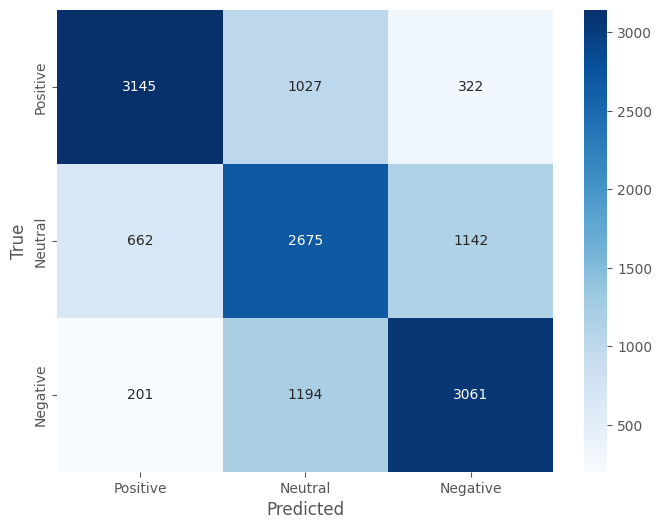

In [ ]:
cm = confusion_matrix(true, pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive', 'Neutral', 'Negative'], yticklabels=['Positive', 'Neutral', 'Negative'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('')
plt.savefig(IMAGE_DIR + 'bert_cm.png', dpi=300, bbox_inches='tight')
plt.show()